In [1]:
from chromatic_fitting import *
import pymc3_ext as pmx
starry.config.lazy = True
starry.config.quiet = True
from chromatic import bintoR, bintogrid
from chromatic_fitting.jwst import planets
from chromatic_fitting.jwst.jwst_utils import get_spot_contrast

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running chromatic_fitting v0.12.7!

This program is running on:
Python v3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
numpy v1.21.6
chromatic v0.4.7
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:22: UserWarning: Celerite2 has not been installed! The GPModel will not work without Celerite2.
  warnings.warn("Celerite2 has not been installed! The GPModel will not work without Celerite2.")


In [2]:
# !pip install git+https://github.com/kevin218/Astraeus.git

### Load in Kepler-51d data from Jessica

In [3]:
k51 = Rainbow("kepler51_stage3/S3_kepler51_ap3_bg7_SpecData.h5")
k51

<🌈(444w, 18082t)>

In [4]:
k51.dt.to_value('s')

2.960836887359619

Bin in time (to speed up everything later on)

In [5]:
k51 = k51.bin(dt=2*u.minute)

  0%|          | 0/444 [00:00<?, ?it/s]

In [6]:
k51

<🌈(444w, 448t)>

  0%|          | 0/448 [00:00<?, ?it/s]

🌈🤖 Of the 235 non-edge new wavelength bins,
40.4% of them effectively contain fewer
than one original wavelength.

Here are your options:
1) Rerun you binning with larger wavelength bin sizes to
decrease the chances that they will be partially populated.
2) Rerun your binning but change `minimum_points_per_bin=` to a number.
This will set a lower limit on the effective number of inputs
points required for each bin. Bins that don't meet this limit
will be marked as not `ok`, and if `trim=True` (default)
these bins will automatically be trimmed away. A threshold
of 1 means bins should average together one or more input
data; a threshold of 0 will get rid of this warning but
allow many bins to come from the same data point, so you
should expect weird correlations.



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

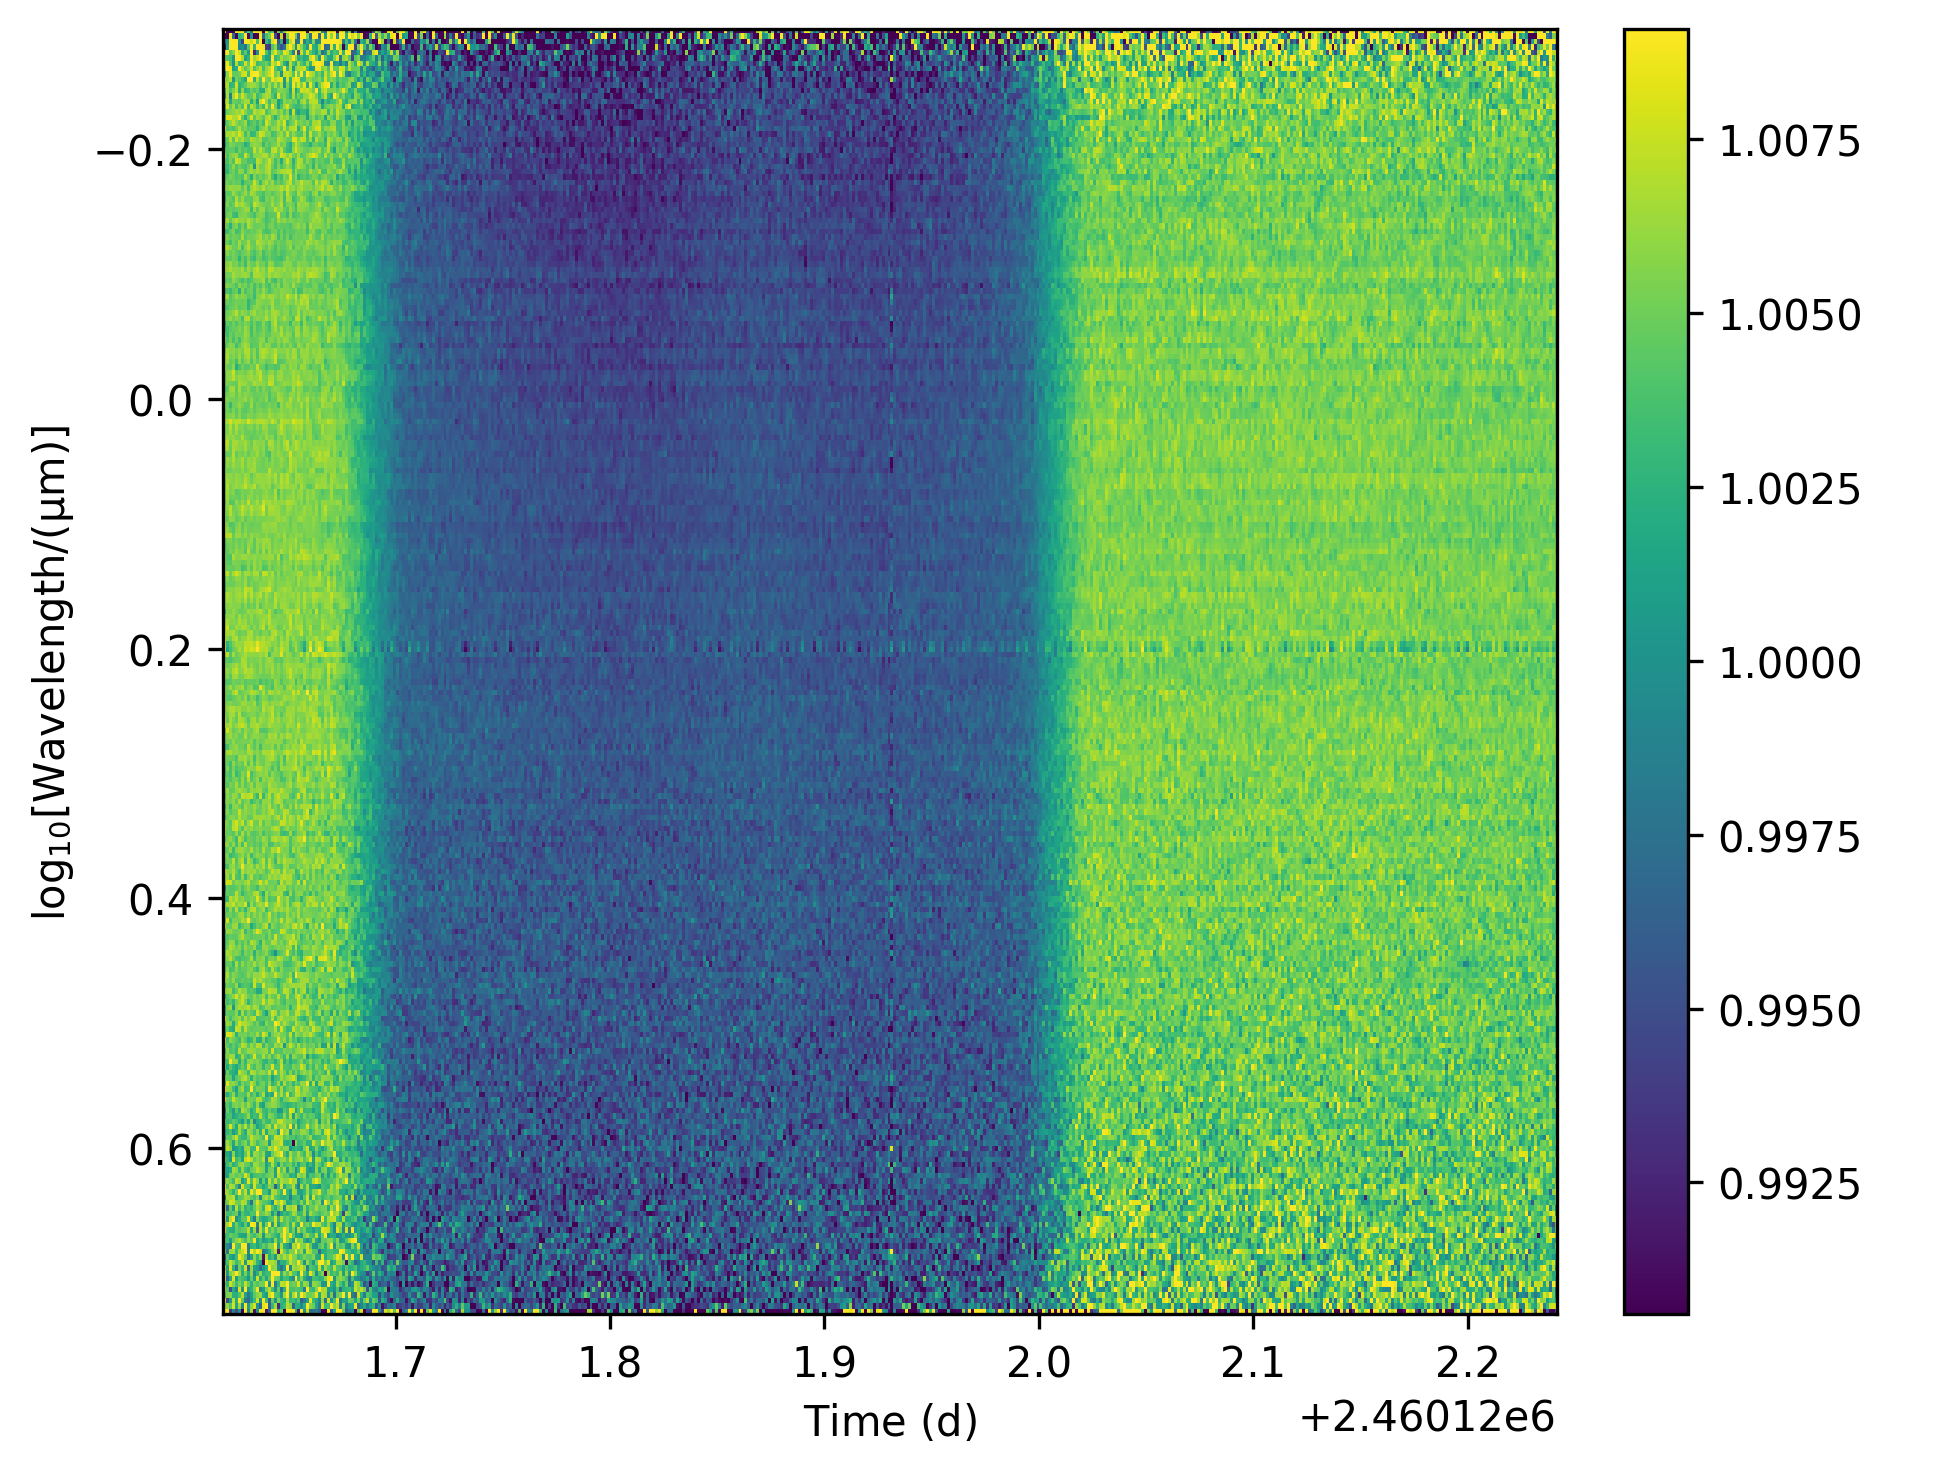

In [45]:
k51.normalize().bin(R=100).imshow()

  0%|          | 0/448 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Relative Flux (+ offsets)'>

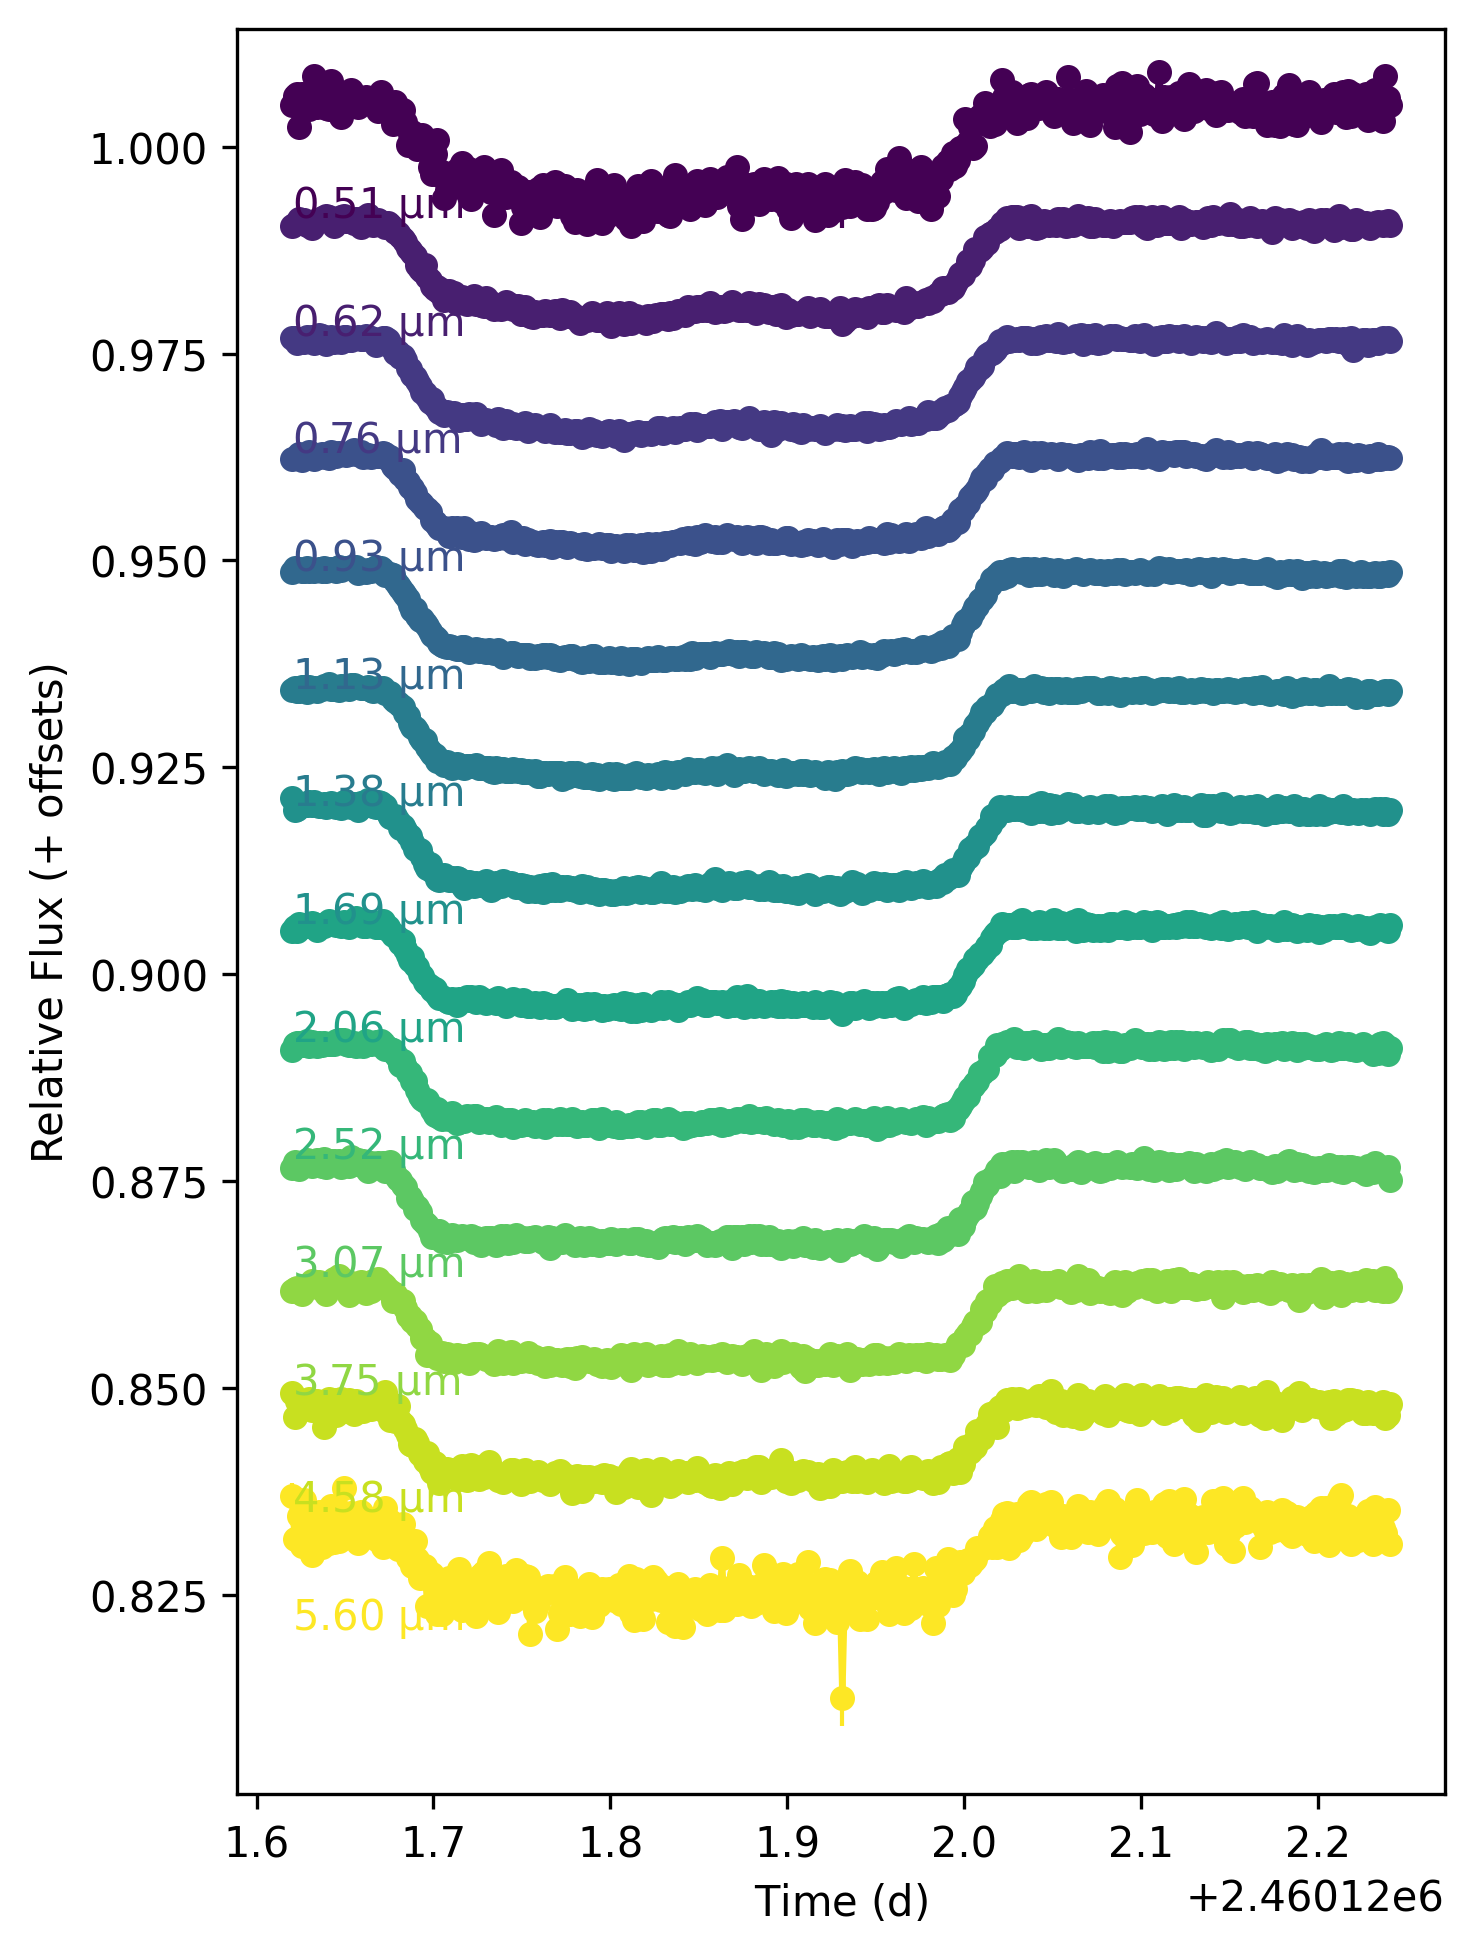

In [46]:
k51.normalize().bin(R=5).plot_lightcurves()
# plt.savefig("wlc.png")

Load in planetary parameters

In [11]:
k51_params, k51d_params = planets.kepler51()
k51_params, k51d_params

({'udeg': 2,
  'inc': 80,
  'amp': 1.0,
  'r': <Quantity 0.881 solRad>,
  'm': <Quantity 0.985 solMass>,
  'prot': 8.222,
  'u': [0.247, 0.267]},
 {'porb': 130.1845,
  'mp': <Quantity 6.5 earthMass>,
  'rp': <Quantity 9.46 earthRad>,
  'ecc': 0.0,
  'omega': -12.6,
  'epoch': 2457778.75336,
  'inc': 89.91})

In [10]:
k51d_params['mp'] = 6.5 * u.M_earth

In [97]:
# s.summary['mean']

In [12]:
from exoplanet.distributions import QuadLimbDark

### Create transit + spot + polynomial model

In [118]:
planet = starry.kepler.Secondary(
    starry.Map(ydeg=0, amp=5e-3),  # the surface map
    m=k51d_params['mp'].to_value("M_sun"),  # mass in solar masses
    inc=k51d_params['inc'],
    r=k51d_params['rp'].to_value("R_sun"),  # radius in solar radii
    porb=k51d_params['porb'],  # orbital period in days
    prot=k51d_params['porb'],  # rotation period in days (synchronous)
    # omega=k51d_params['omega'],  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    # w=0,  # longitude of pericenter in degrees
    t0=2460121.8473359,  # time of transit in days
)

ld_coeffs = k51_params['u']
star_kw={'m':k51_params['m'].to_value('M_sun'),'r':k51_params['r'].to_value('R_sun'),'prot': k51_params['prot']}

# time = np.linspace(0.916, 1.084, 200)
time = k51.time.to_value('d')
ydeg = 30

star = starry.Primary(starry.Map(ydeg=ydeg, udeg=2, amp=1.0, inc=80), **star_kw)
star.t0=2460121.8473359
star.theta0=0
star.map[1] = ld_coeffs[0]  #-0.02
star.map[2] = ld_coeffs[1]  #0.185
star.map.spot(contrast=1, radius=45, lat=-50, lon=7, spot_smoothing=1/ydeg)

system = starry.System(star, planet)
flux_model = system.flux(time)
flux_model = flux_model/flux_model[0]

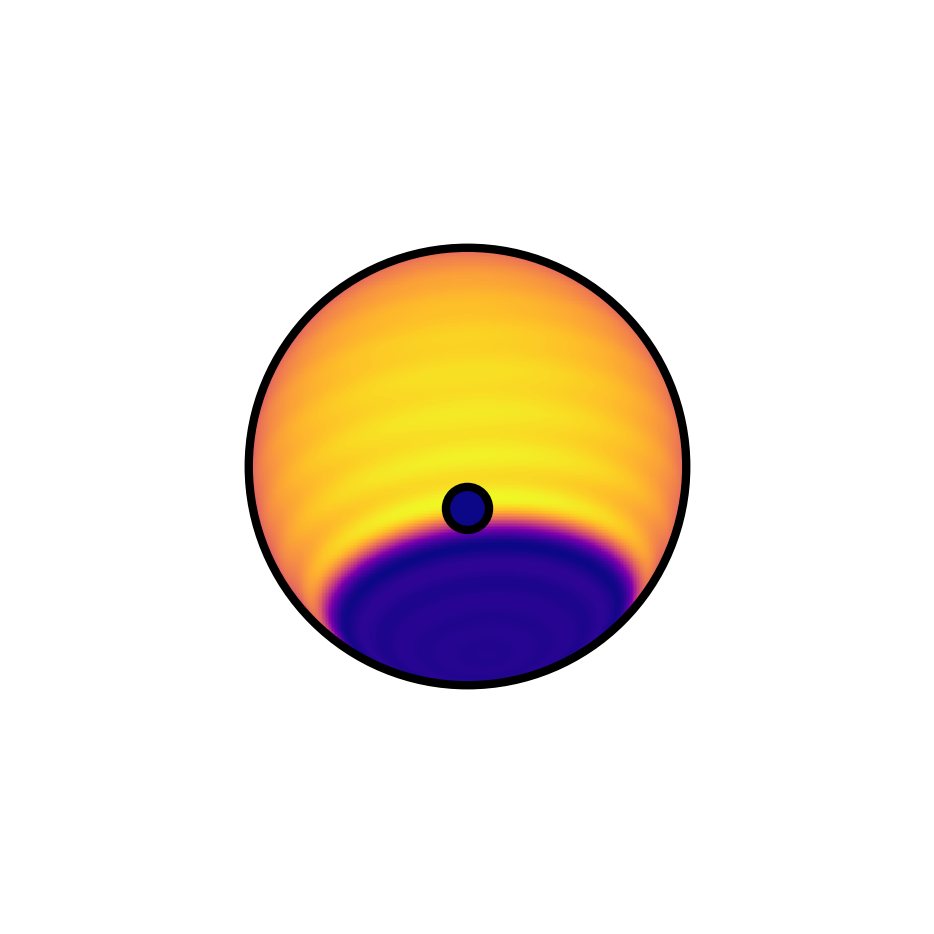

In [119]:
system.show(t=2460121.8473359)

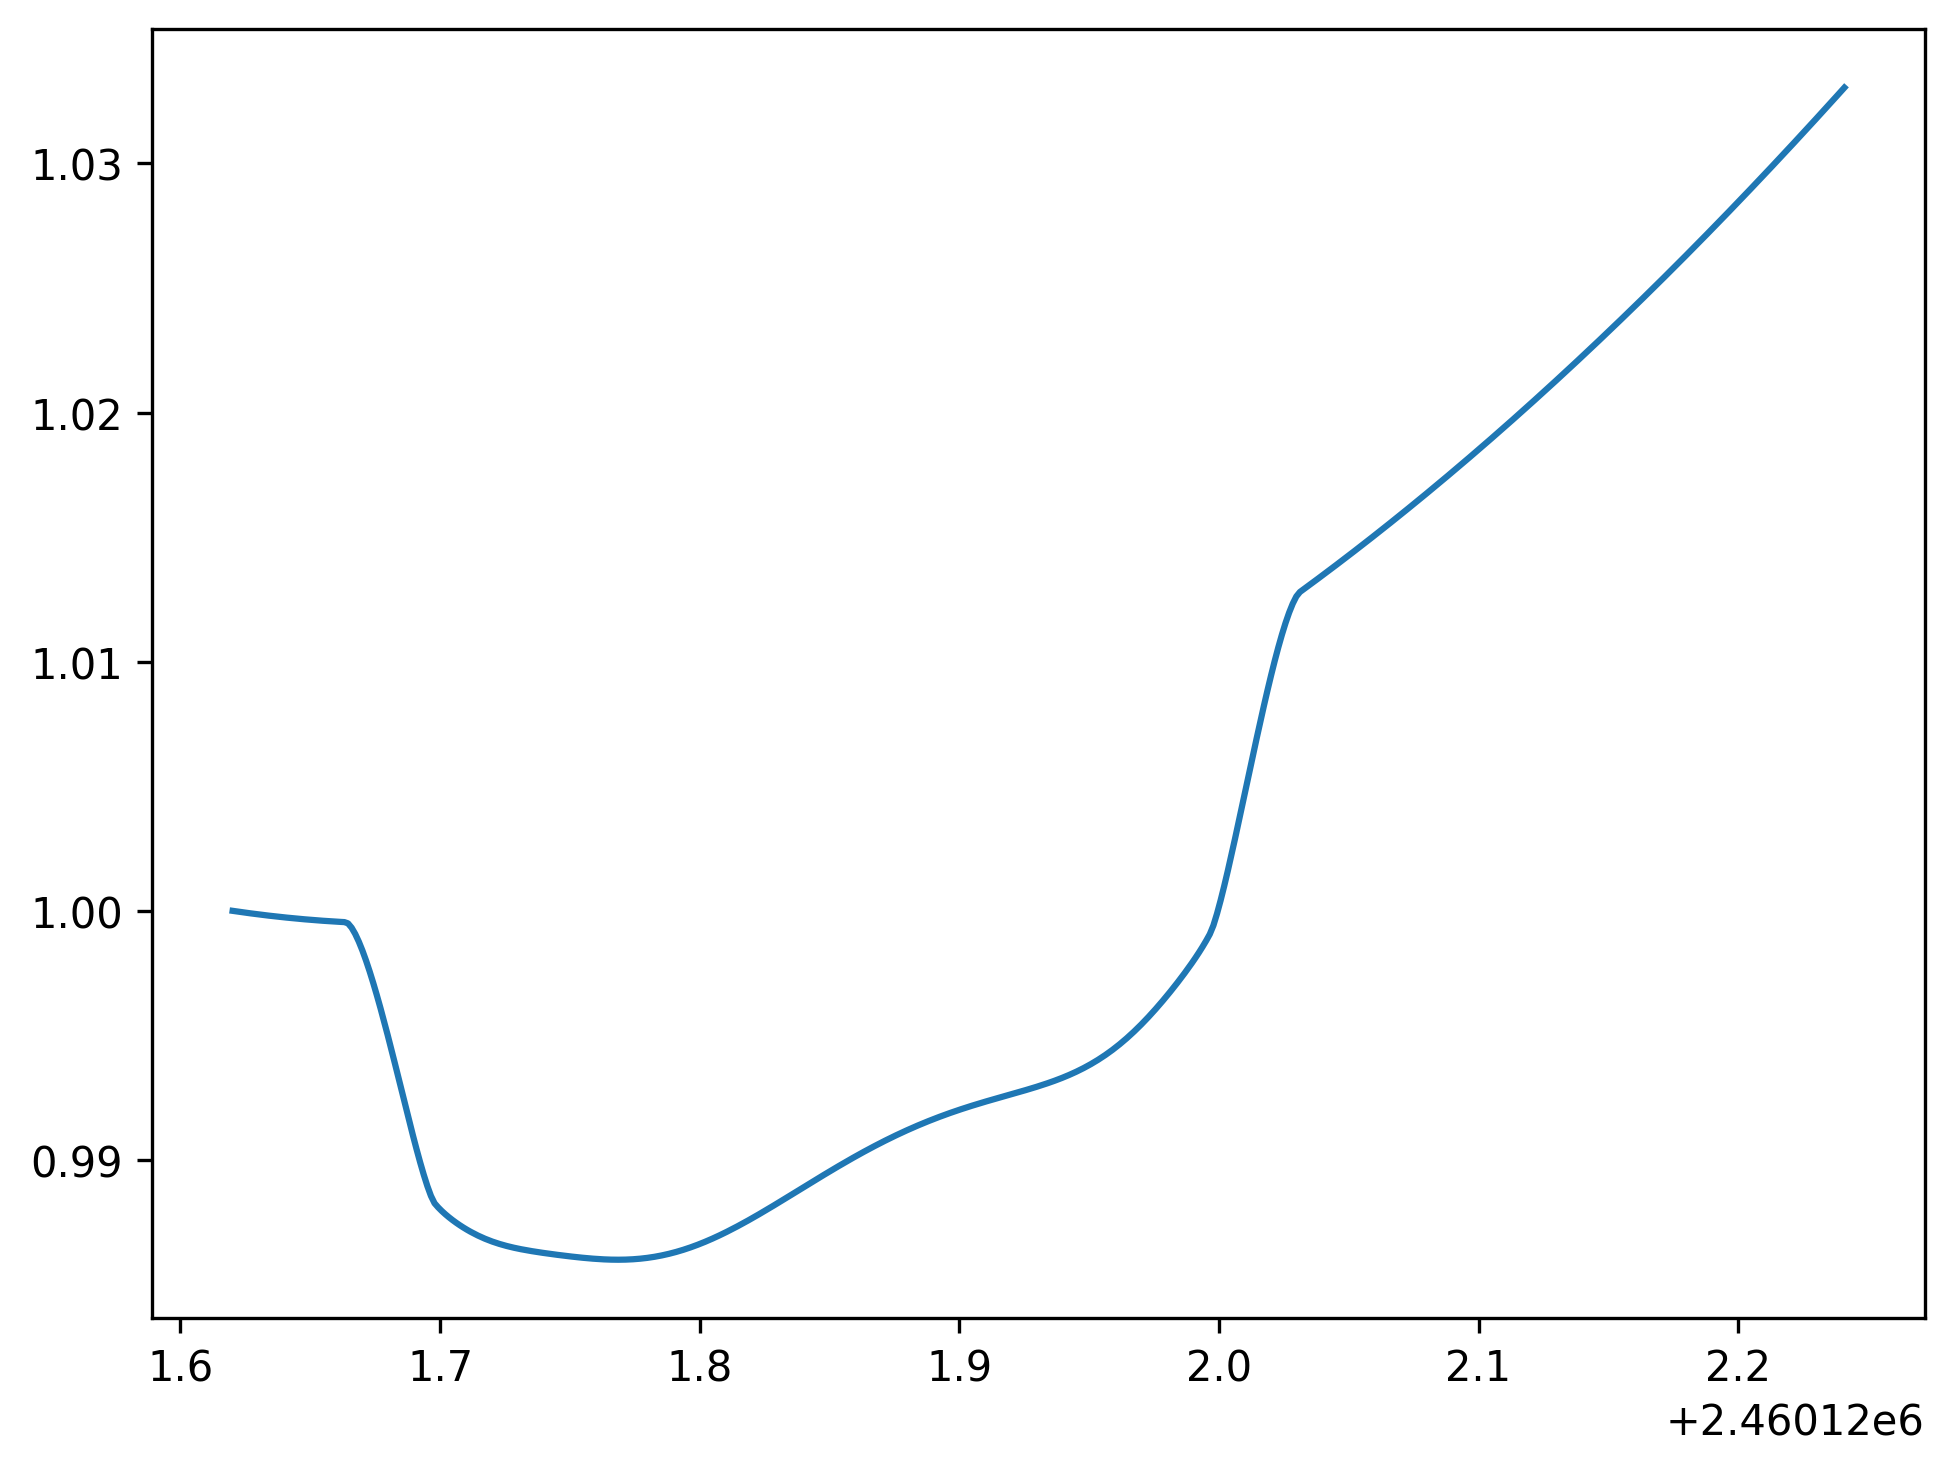

In [120]:
plt.plot(time, flux_model.eval())

In [125]:
sp = TransitSpotModel(ydeg=26, spot_smoothing=1/26, nspots=1)#22, spot_smoothing=1/22, nspots=1)

wl_params = {'rs':Fitted(TruncatedNormal,lower=0, mu=k51_params["r"].to_value('R_sun'),testval=k51_params["r"].to_value('R_sun'), sigma=0.011), # stellar radius in Sun radius 
    'ms':Fitted(Normal, mu=k51_params["m"].to_value('M_sun'), sigma=0.012), # stellar mass in Sun masses 
    'prot':k51_params["prot"], # stellar rotation period
    'u':WavelikeFitted(QuadLimbDark, testval=k51_params['u'], shape=2),#Fitted(Normal, mu=[0.3,0.3], sigma=0.1, shape=2),#hatp18_params["u"], # limb-darkening coeffs
    'stellar_inc':Fitted(Normal, mu=90, sigma=5, testval=90), #90, #Fitted(Uniform, lower=75, upper=85, testval=80),
    
    # spot 1 parameters
    'spot_contrast' : WavelikeFitted(Uniform, lower=0.0, upper=1.0, testval=0.3),
    '1_spot_1_radius' : Fitted(Uniform, lower=5.0, upper=45.0, testval=20), 
    '1_spot_1_latitude' : Fitted(Uniform,lower=-50, upper=50, testval=10),
    '1_spot_1_longitude' : Fitted(Uniform, lower=0, upper=90, testval=5),

    # planet parameters
    'mp':Fitted(Normal, mu=k51d_params['mp'].to_value('M_earth'), sigma=1.12), #Fitted(Normal, mu=toi3884b_params['mp'], sigma=0.1), # planet mass in Earth masses
    'rp':WavelikeFitted(TruncatedNormal, lower=0.0, mu=k51d_params['rp'].to_value('R_earth'), sigma=0.5,
                     testval=k51d_params['rp'].to_value('R_earth')), # planet radius in Earth radii
    'inc':Fitted(Normal, mu=k51d_params["inc"],sigma=0.1), #
    'period':k51d_params['porb'], 
    'ecc':k51d_params['ecc'], 
    't0': Fitted(Normal, mu=2460121.8473359, sigma=0.01),
        }

# params = {'rs':0.865267, #Fitted(TruncatedNormal,lower=0, mu=k51_params["r"].to_value('R_sun'),testval=k51_params["r"].to_value('R_sun'), sigma=0.011), # stellar radius in Sun radius 
#     'ms':0.990581, #Fitted(Normal, mu=k51_params["m"].to_value('M_sun'), sigma=0.012), # stellar mass in Sun masses 
#     'prot':k51_params["prot"], # stellar rotation period
#     'u':WavelikeFitted(TruncatedNormal, mu=k51_params['u'], sigma=0.1, lower=[0,-1], upper=[2,1], testval=k51_params['u'], shape=2),#Fitted(Normal, mu=[0.3,0.3], sigma=0.1, shape=2),#hatp18_params["u"], # limb-darkening coeffs
#     'stellar_inc':90,#Fitted(Normal, mu=90, sigma=5, testval=90), #90, #Fitted(Uniform, lower=75, upper=85, testval=80),
    
#     # spot 1 parameters
#     'spot_contrast' : WavelikeFitted(Uniform, lower=0.0, upper=1.0, testval=0.15),
#     '1_spot_1_radius' : 14.981099, #Fitted(Uniform, lower=5.0, upper=30.0, testval=10), 
#     '1_spot_1_latitude' : -2.518041, #Fitted(Uniform,lower=-90, upper=90, testval=0.1),
#     '1_spot_1_longitude' : 6.542516, #Fitted(Uniform, lower=-180, upper=180, testval=0.1),

#     # 'spot_contrast':WavelikeFitted(Uniform, lower=0.0, upper=1.0, testval=0.3),
#     # '1_spot_1_radius':Fitted(Uniform, lower=5.0, upper=30.0, testval=10), 
#     # '1_spot_1_latitude':Fitted(Uniform,lower=-90, upper=90, testval=0.1),
#     # '1_spot_1_longitude':Fitted(Uniform, lower=-180, upper=180, testval=0.1),

#     # planet parameters
#     'mp':k51d_params['mp'].to_value('M_earth'), #Fitted(Normal, mu=k51d_params['mp'].to_value('M_earth'), sigma=1.12), #Fitted(Normal, mu=toi3884b_params['mp'], sigma=0.1), # planet mass in Earth masses
#     'rp':WavelikeFitted(TruncatedNormal, lower=0.0, mu=k51d_params['rp'].to_value('R_earth'), sigma=0.5,
#                      testval=k51d_params['rp'].to_value('R_earth')), # planet radius in Earth radii
#     'inc':89.872891,#Fitted(Normal, mu=k51d_params["inc"],sigma=0.1), #
#     'period':k51d_params['porb'], 
#     # omega=Fitted(Normal, mu=k51d_params['omega'], sigma=68), 
#     'ecc':k51d_params['ecc'], 
#     't0':2460121.8473359 #Fitted(Normal, mu=2460121.847, sigma=0.01),
#          }

sp.setup_parameters(**wl_params)

p = PolynomialModel(degree=2)
p.setup_parameters(
    p_0 = WavelikeFitted(Normal, mu=1.0, sigma=1e-2),
    p_1 = WavelikeFitted(Normal,mu=0.0,sigma=1e-2),
    p_2 = WavelikeFitted(Normal,mu=0.0,sigma=1e-3),
    )

s = sp * p

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/transit_and_spot.py:44: UserWarning: You have selected >=25 spherical harmonic degrees. Starry will be very slow!
  warnings.warn(
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:171: UserWarning: transitspot in the parameter name: transitspot_A. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:171: UserWarning: polynomial in the parameter name: polynomial_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(


In [126]:
# s.summarize_parameters()

In [127]:
# i_start, i_end = 410, 420
s.attach_data(k51.normalize())#.bin(R=5))#[i_start:i_end,:])
s.choose_optimization_method("white_light")

In [128]:
# s.attach_data(k51.normalize().bin(R=5))
# s.choose_optimization_method("separate")
# i_start, i_end = "R5", ""

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


  0%|          | 0/448 [00:00<?, ?it/s]

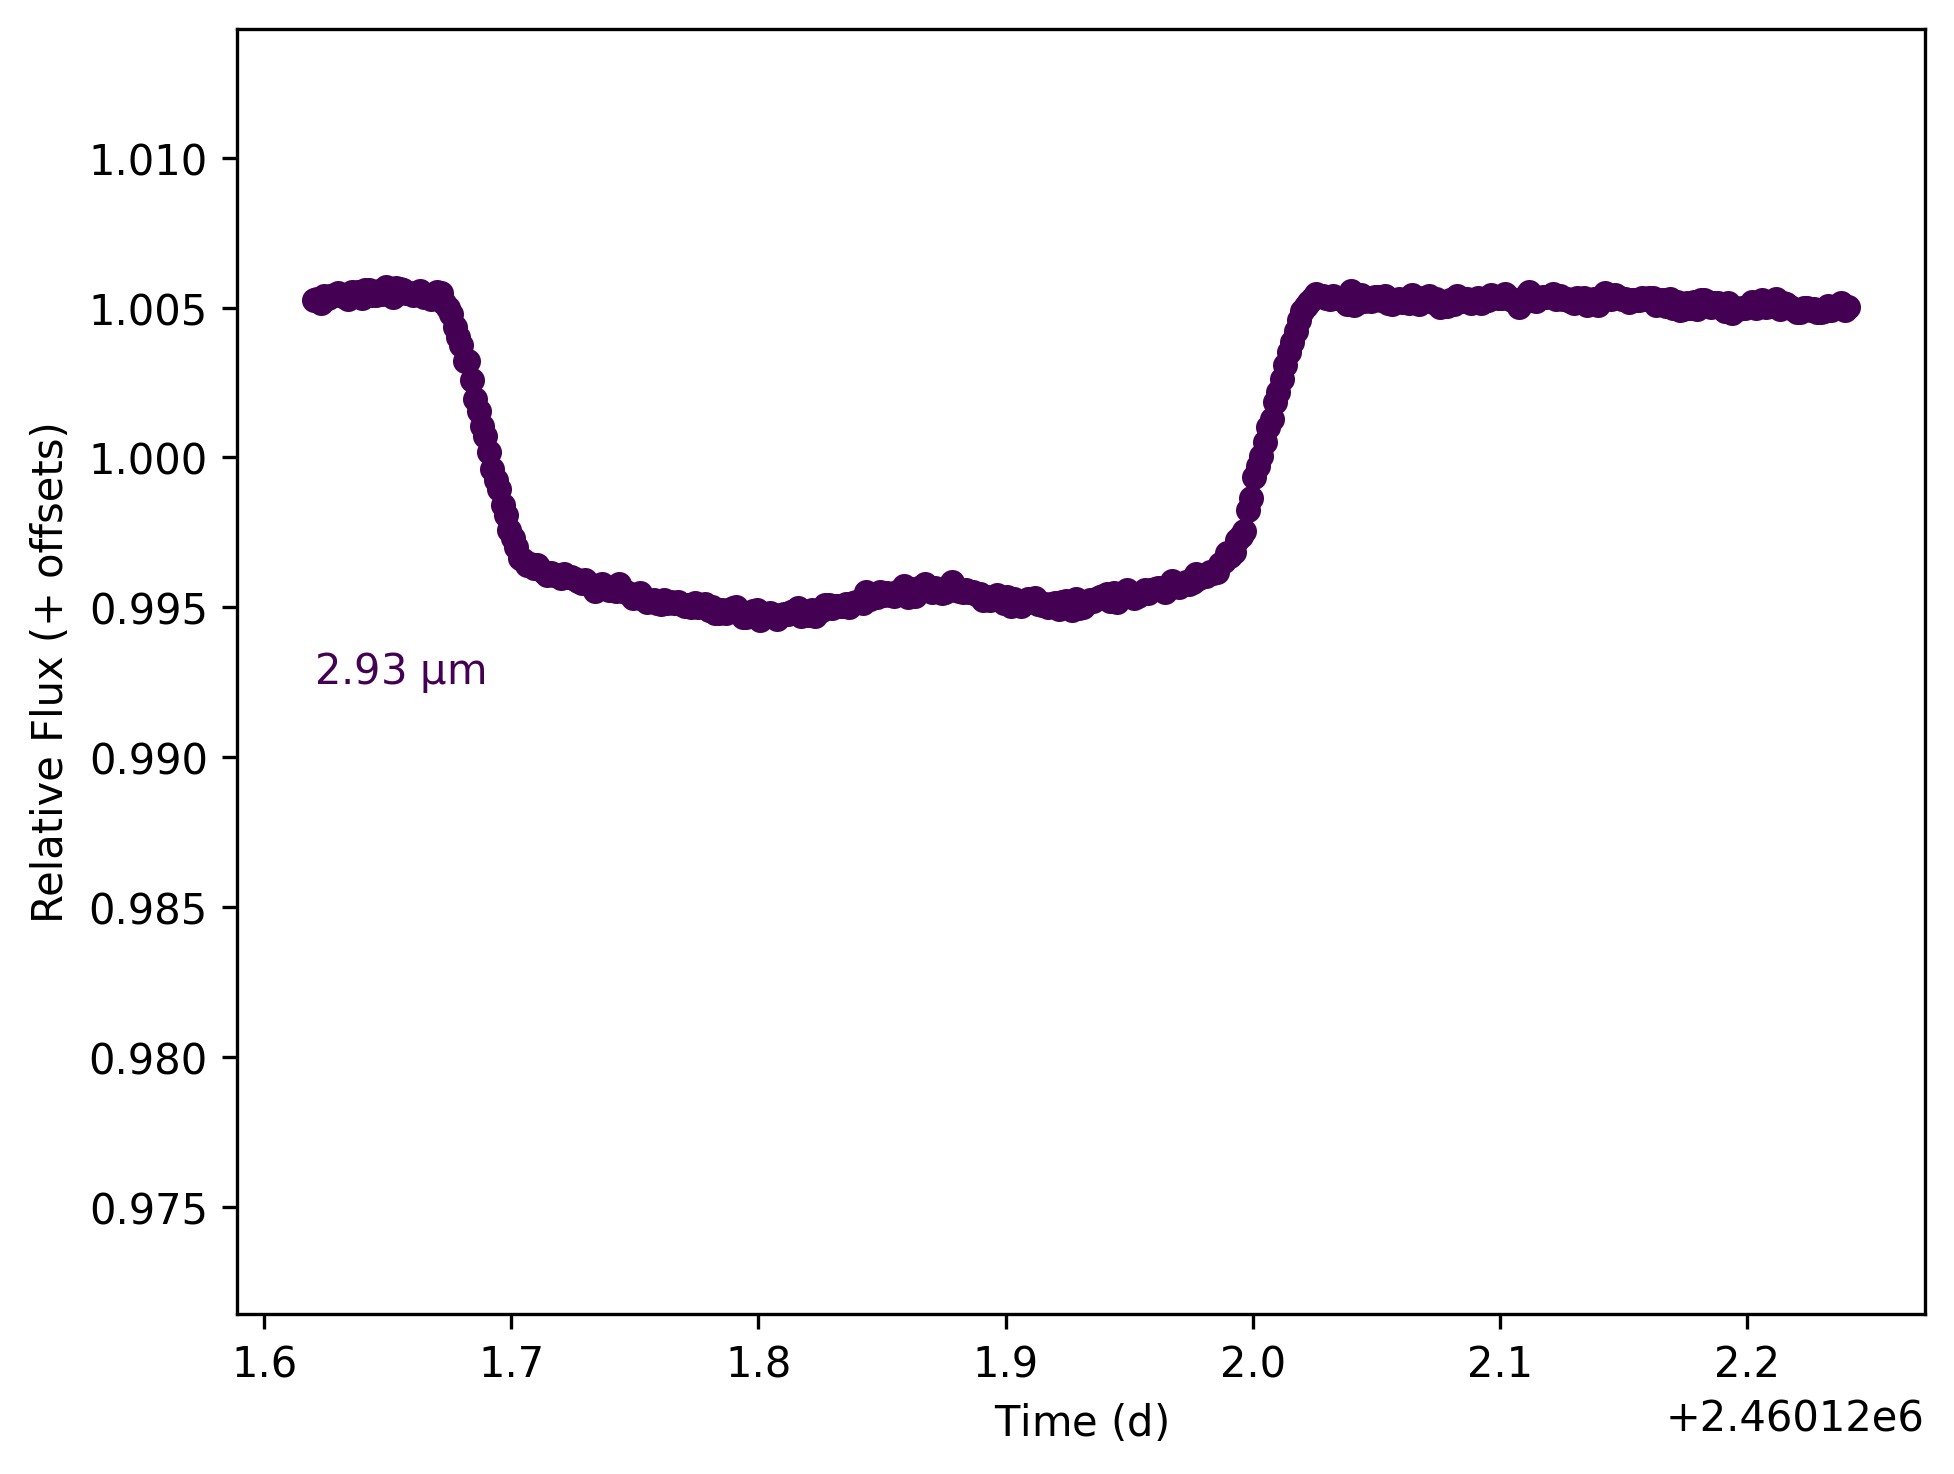

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Relative Flux (+ offsets)'>

In [129]:
s.plot_lightcurves() 

In [130]:
s.data

<🌈(444w, 448t)>

Include a parameter for inflating uncertainties per wavelength

In [131]:
nsig = WavelikeFitted(TruncatedNormal, mu=1.0, sigma=0.005, lower=1.0, upper=3.0, testval=1.01)
s.setup_likelihood(inflate_uncertainties=True, inflate_uncertainties_prior=nsig)

.setup_lightcurves() has not been run yet, running now...


  0%|          | 0/448 [00:00<?, ?it/s]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


  0%|          | 0/448 [00:00<?, ?it/s]

MAP-optimize the models to get initial values for sampling

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Can

message: Desired error not necessarily achieved due to precision loss.
logp: -88990119.57757251 -> 3178.121588544841
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (thean

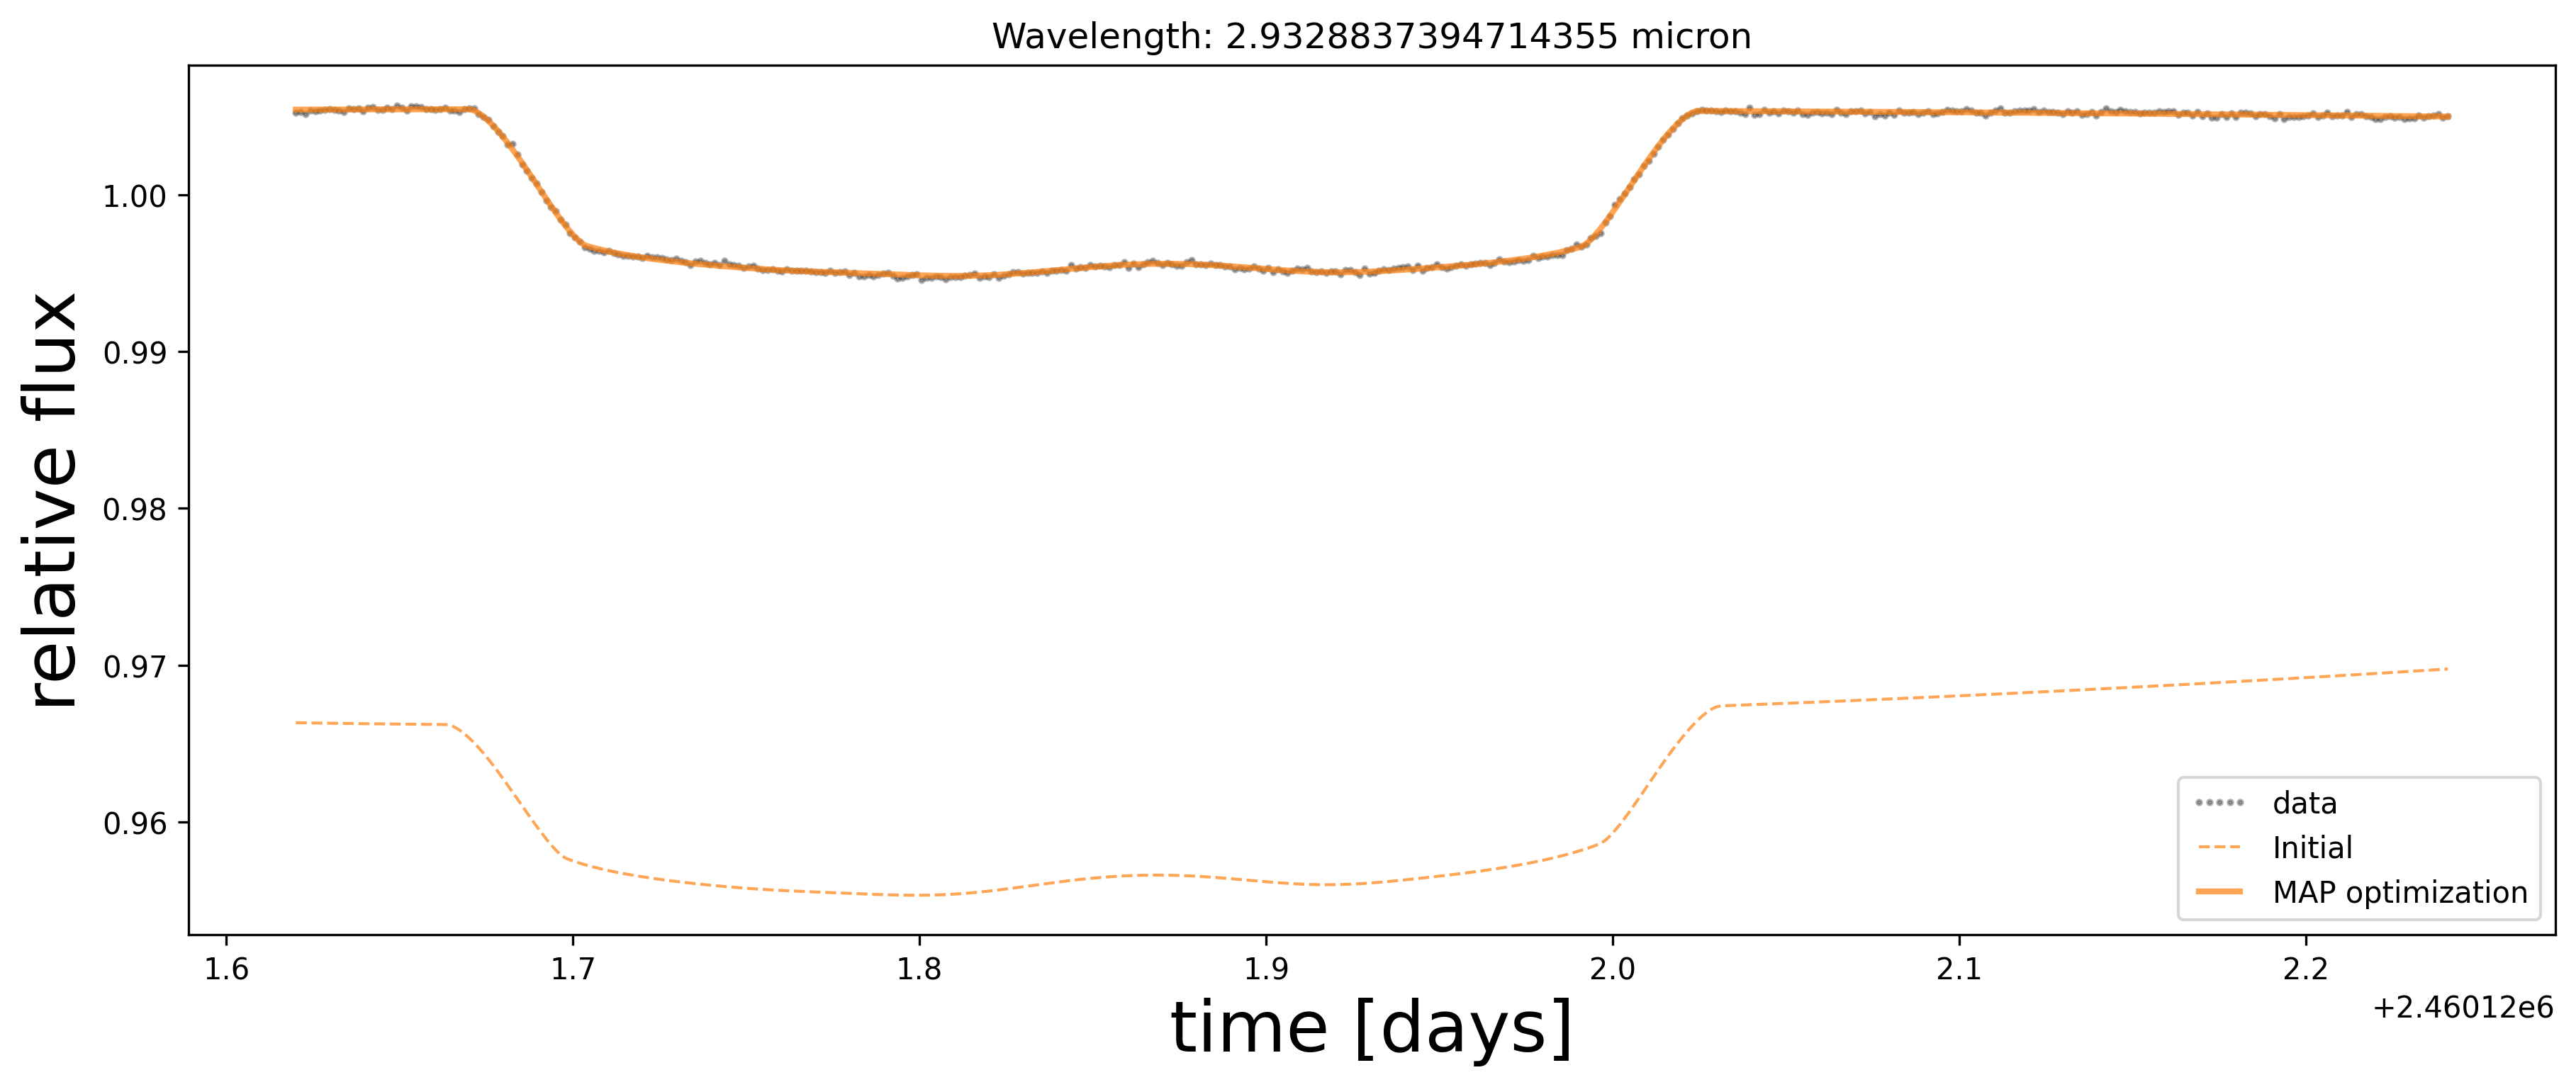

In [132]:
opt = s.optimize(plot=True)

# try a range of initial conditions to avoid getting stuck in a local minima!
# logp, opts, latlon = [], [],[]
# for lat in [-60, -30, 0, 30, 60]:
#     # if lat != 89.9:
#     for lon in [0.1, 45, 90, 180, 270]:#np.linspace(0.1, 315, 8):#
#             # print(lat, lon)
#         opt = s.optimize(plot=False, start={'transitspot_1_spot_1_longitude':lon,
#                                                'transitspot_1_spot_1_latitude':lat})
#         opts.append(opt)
#         logp.append(s._pymc3_model.logp(opt))
#         latlon.append((lat,lon))
#     # else:
#     #     opt = s.optimize(plot=False, start={'transitspot_1_spot_1_latitude':lat})
#     #     opts.append(opt)
#     #     logp.append(s._pymc3_model.logp(opt))
#     #     latlon.append((lat,0))

# print(f"Highest logp = {np.max(logp)}, for {latlon[np.argmax(logp)]}")
# opt = s.optimize(plot=True, start=opts[np.argmax(logp)])

In [54]:
# s._pymc3_model

MCMC (NUTS) Sample. I have an issue with running multiple cores on my machine - this might not be an issue for everyone... You can also try removing the `mp_ctx` kw and trying again 

In [134]:
opt#[0]

{'transitspot_rs_lowerbound__': array([-0.14600095]),
 'transitspot_ms': array([0.99155547]),
 'transitspot_stellar_inc': array([90.]),
 'transitspot_u_quadlimbdark__': array([-0.54280809, -1.60167416]),
 'transitspot_mp': array([6.50017151]),
 'transitspot_rp_lowerbound__': array([2.20821533]),
 'transitspot_inc': array([89.88198049]),
 'transitspot_t0': array([2460121.8473496]),
 'transitspot_spot_contrast_interval__': array([-0.93218278]),
 'transitspot_1_spot_1_radius_interval__': array([-0.46709102]),
 'transitspot_1_spot_1_latitude_interval__': array([0.30833058]),
 'transitspot_1_spot_1_longitude_interval__': array([-2.49133635]),
 'polynomial_p_0': array([1.03835803]),
 'polynomial_p_1': array([-0.00133064]),
 'polynomial_p_2': array([-0.00051778]),
 'nsigma_interval__': array([-4.32293438]),
 'transitspot_rs': array([0.86415688]),
 'transitspot_u': array([0.20339292, 0.40285339]),
 'transitspot_rp': array([9.09946239]),
 'transitspot_spot_contrast': array([0.28248209]),
 'tran

In [ ]:
s.sample(start=opt, sampling_method=pmx.sample, draws=3000, tune=2000, chains=2, cores=1)#, mp_ctx="spawn",)

Sampling model using the <function sample at 0x2981cfdc0> method


/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Can

In [14]:
i_start

410

### Plot and Save Results

In [60]:
s.data.nwave

13

In [61]:
res = "R10/ydeg26" #"native_res"
i_start = 0
i_end = s.data.nwave
svname = f"{res}/k51_{i_start}_{i_end}"
pickle.dump(s._pymc3_model, open(f"{svname}_pymc3model.pkl", 'wb'))
pickle.dump(s.summary, open(f"{svname}_summary.pkl", 'wb'))
pickle.dump(s.trace, open(f"{svname}_trace.pkl", 'wb'))

In [62]:
s.write_chromatic_model(f"{svname}.chromfit.npy")

In [17]:
# s = np.load("native_res/k51_60_100.rainbow.npy", allow_pickle=True)
# svname = f"native_res/k51_{60}_{100}"

In [ ]:
read_chromatic_model(f"R10/ydeg26/k51_{i_start}_{i_end}"

In [18]:
s.data

<🌈(10w, 448t)>

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

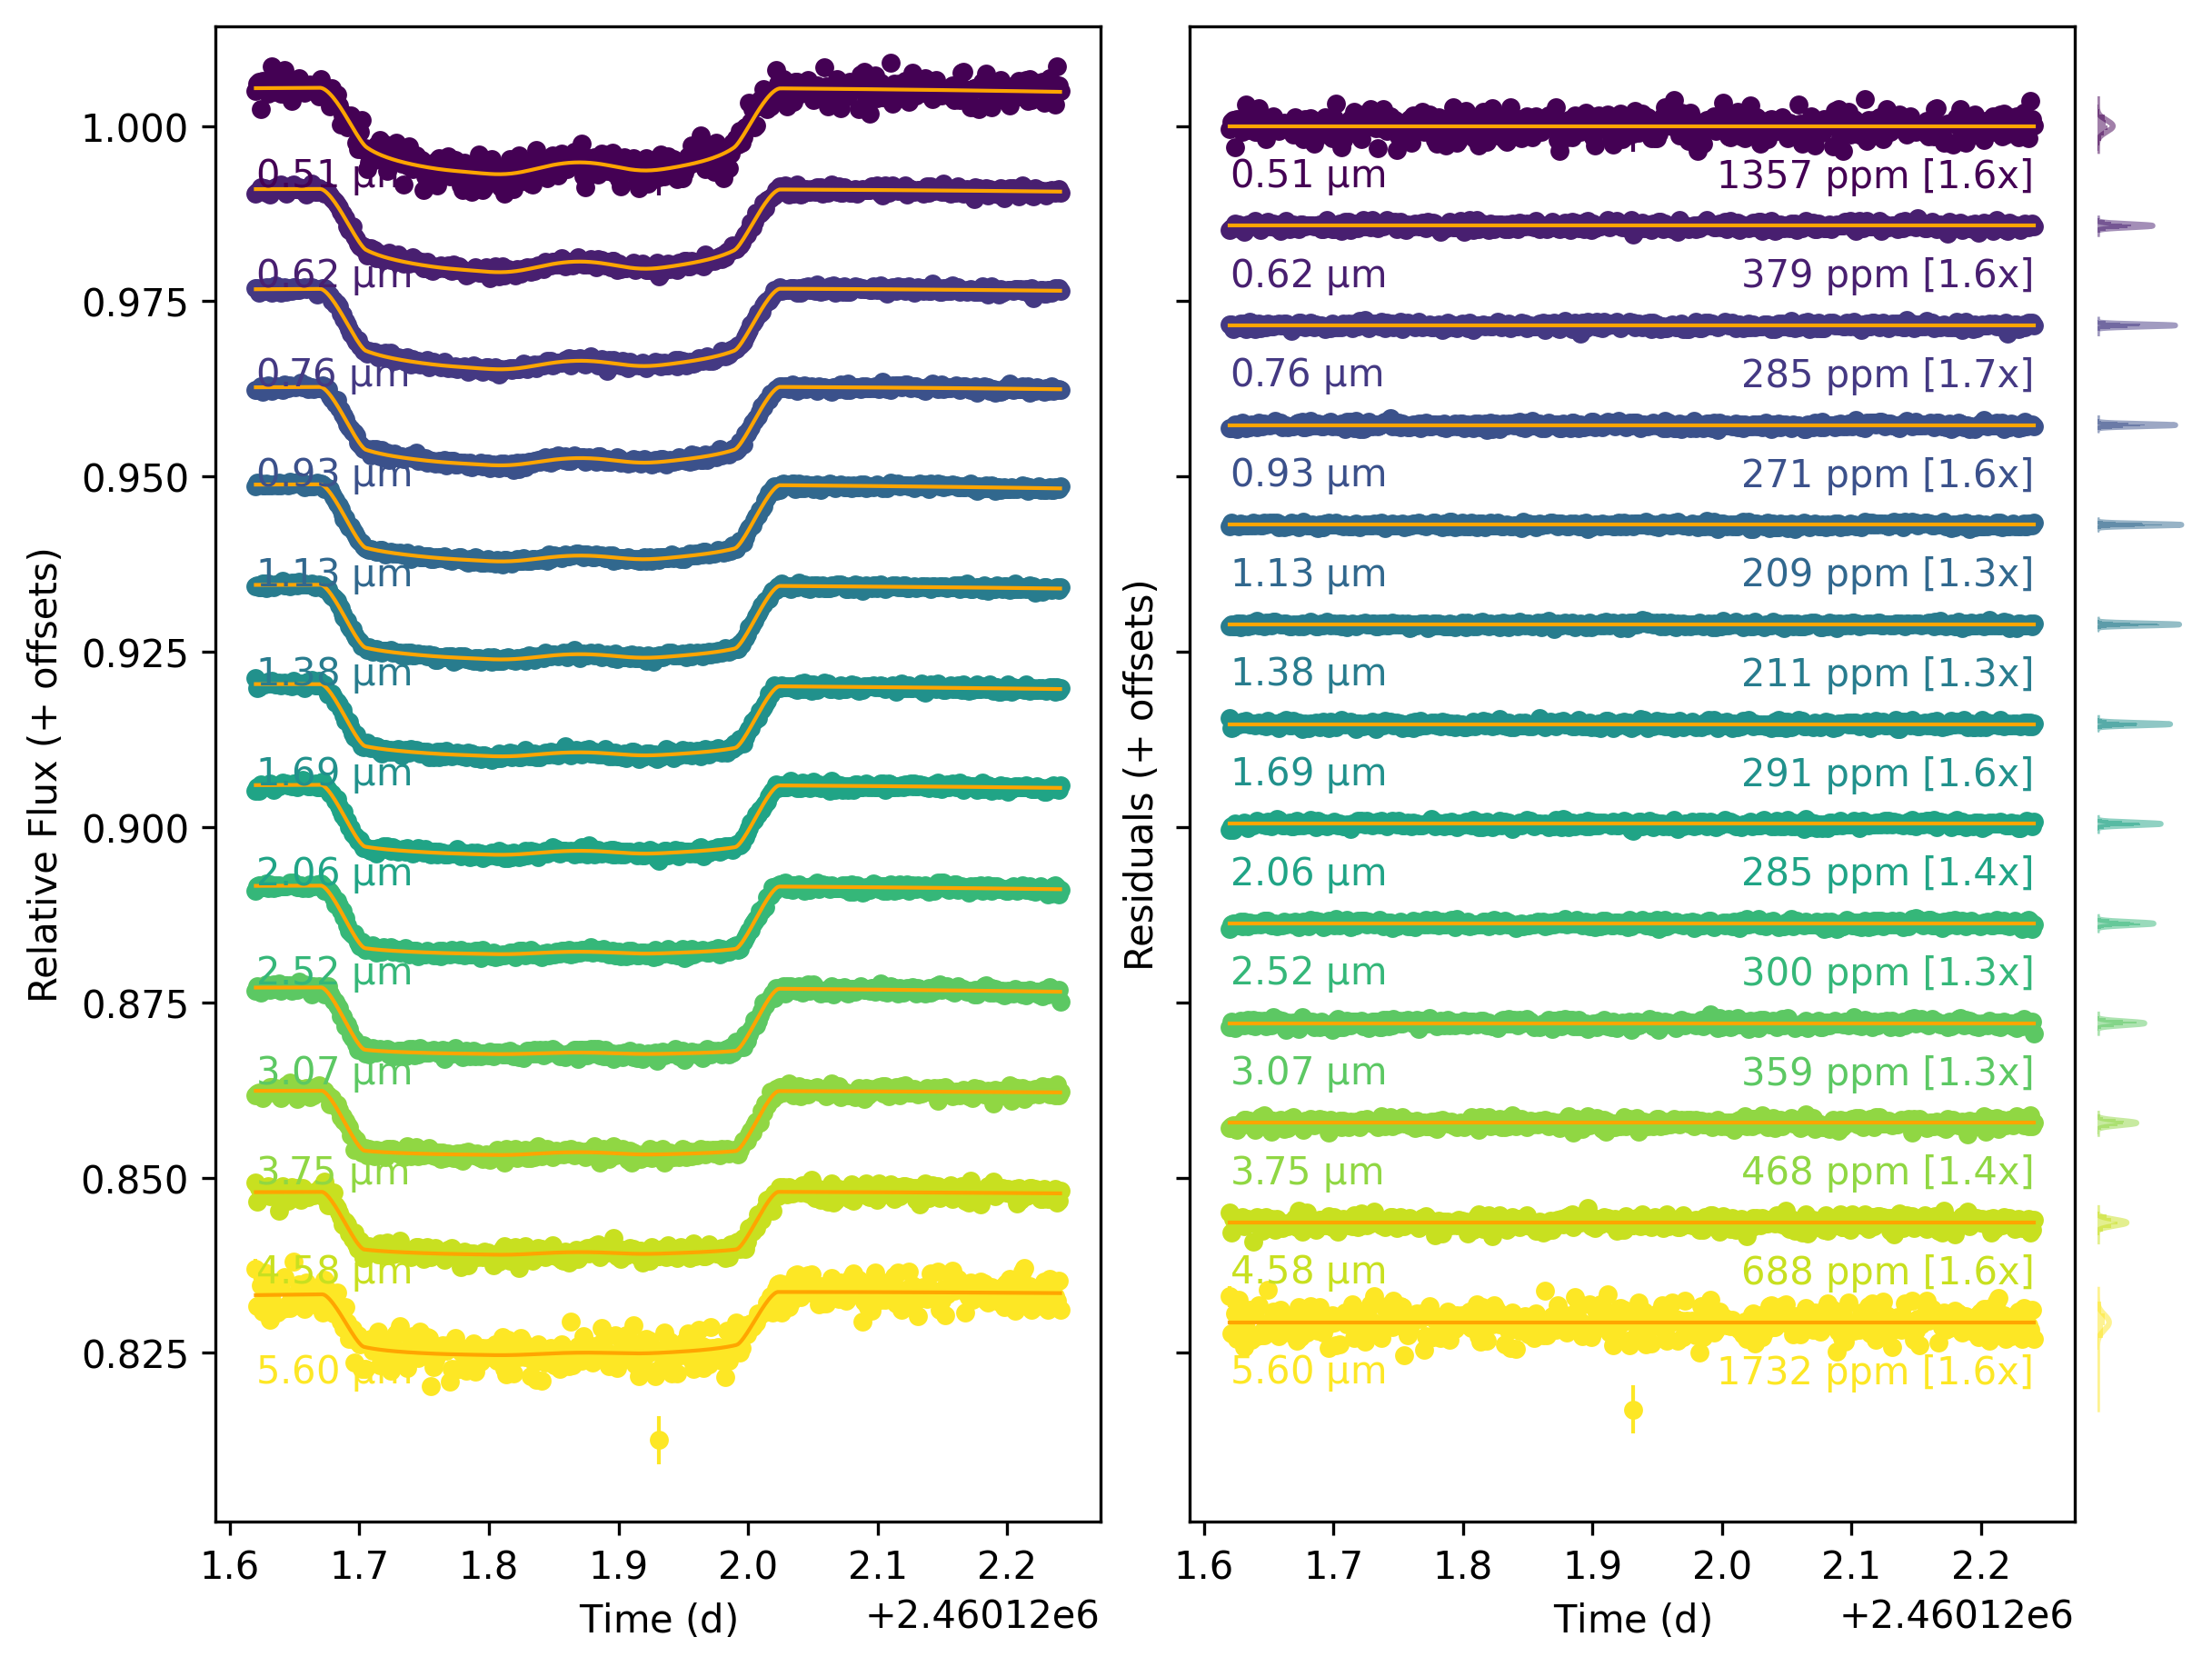

In [63]:
s.plot_with_model_and_residuals(model_plotkw={'zorder':0, 'color':'orange'})
plt.savefig(f"{svname}_modelfit.png")

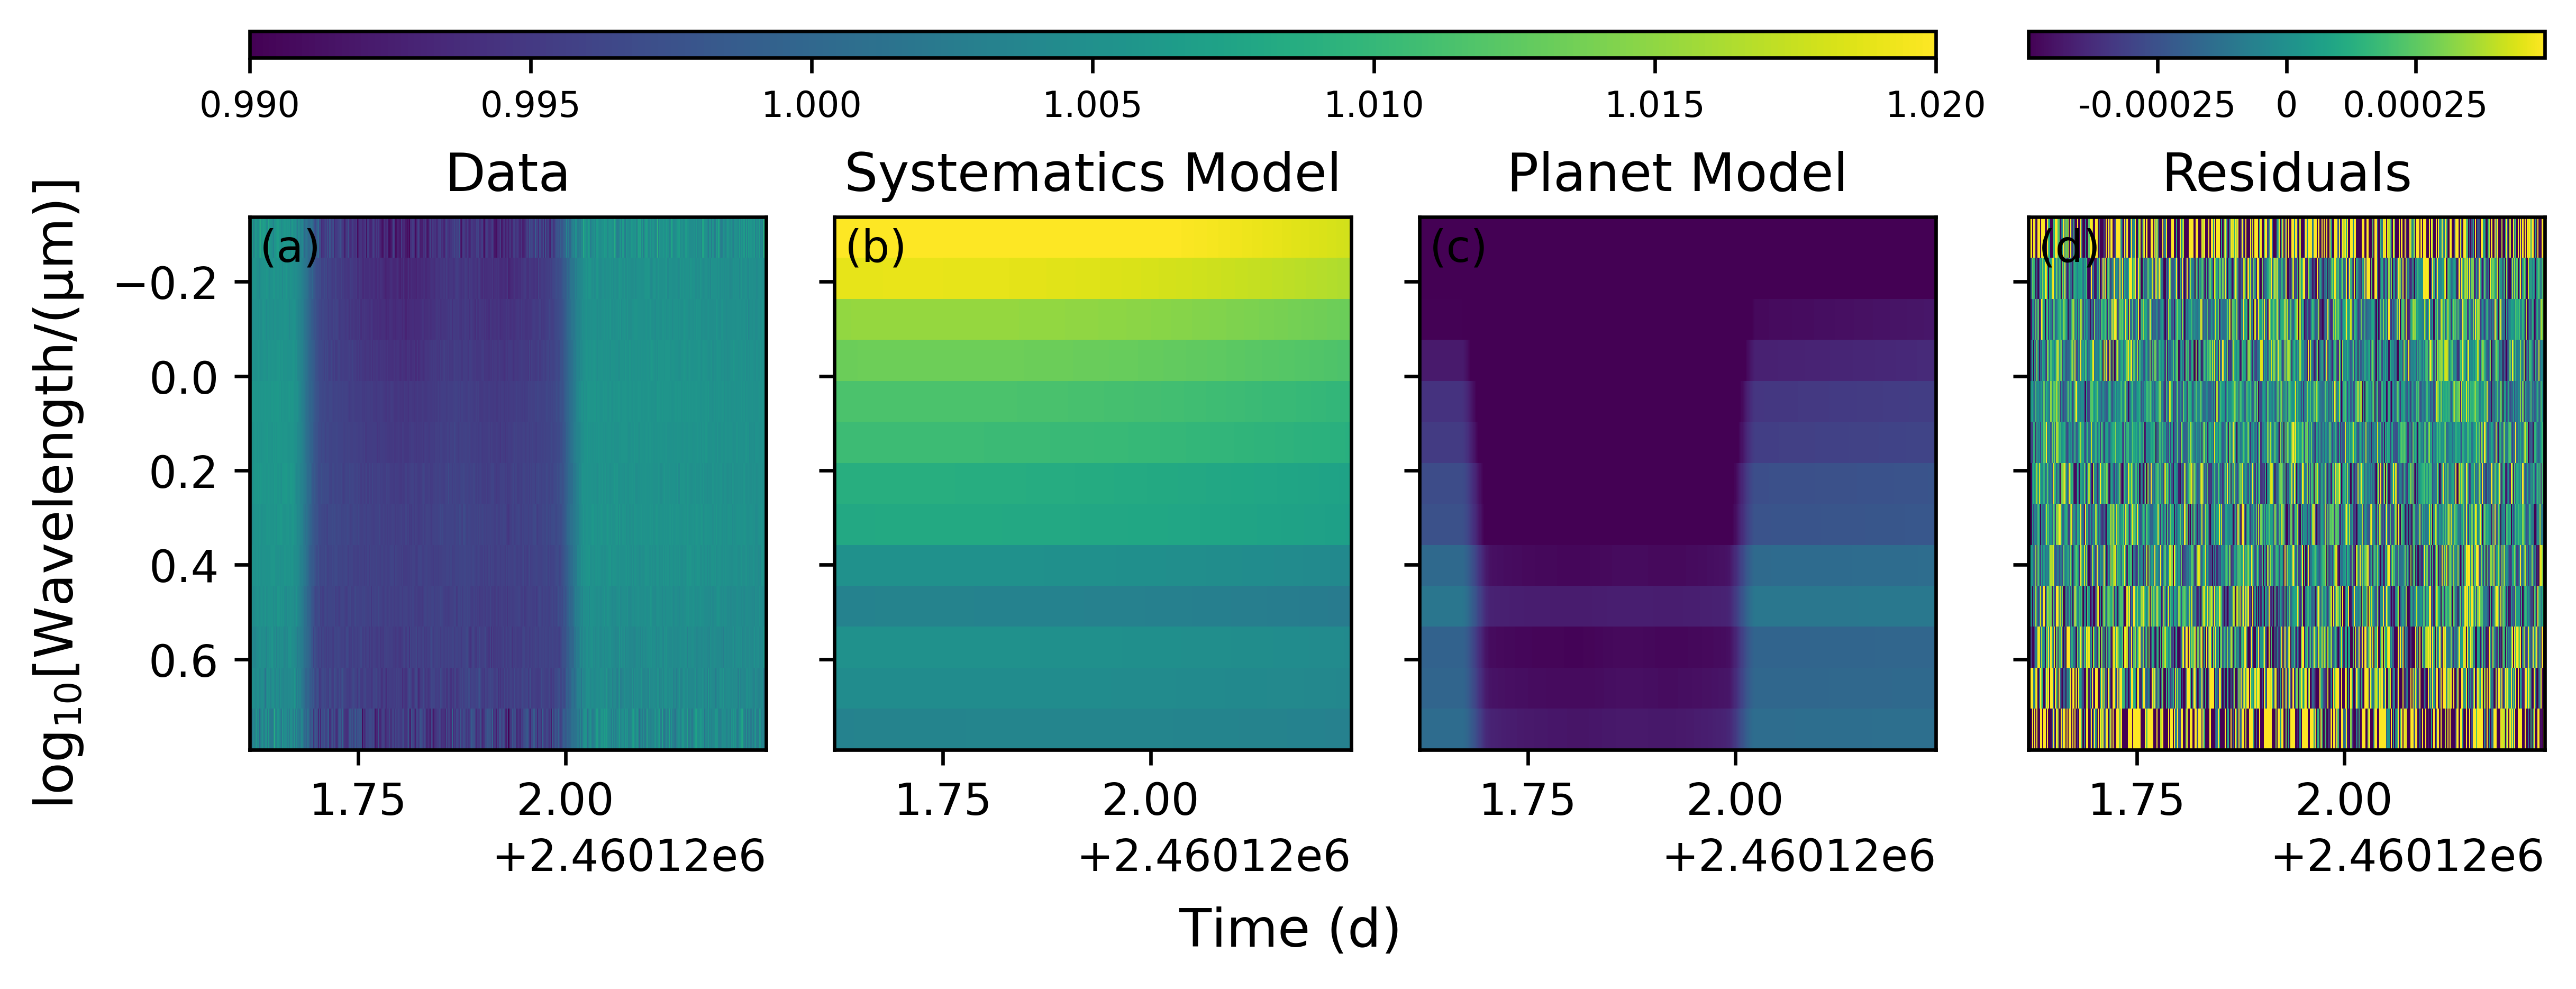

In [64]:
s.imshow_with_models(vlimits_data=[0.99, 1.02], vspan_residuals=0.0005)
plt.savefig(f"{svname}_imshow.png")

In [21]:
# !pip install ffmpeg
# !conda install -c conda-forge ffmpeg

In [22]:
# s._chromatic_models['transitspot'].keplerian_system.show(t=s.data.time)#t=2460121.83)

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_{param}_neg_error"] = (
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_{param}_neg_error"] = (


Error applying make_transmission_spectrum_table to <chromatic polynomial model 'polynomial' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'


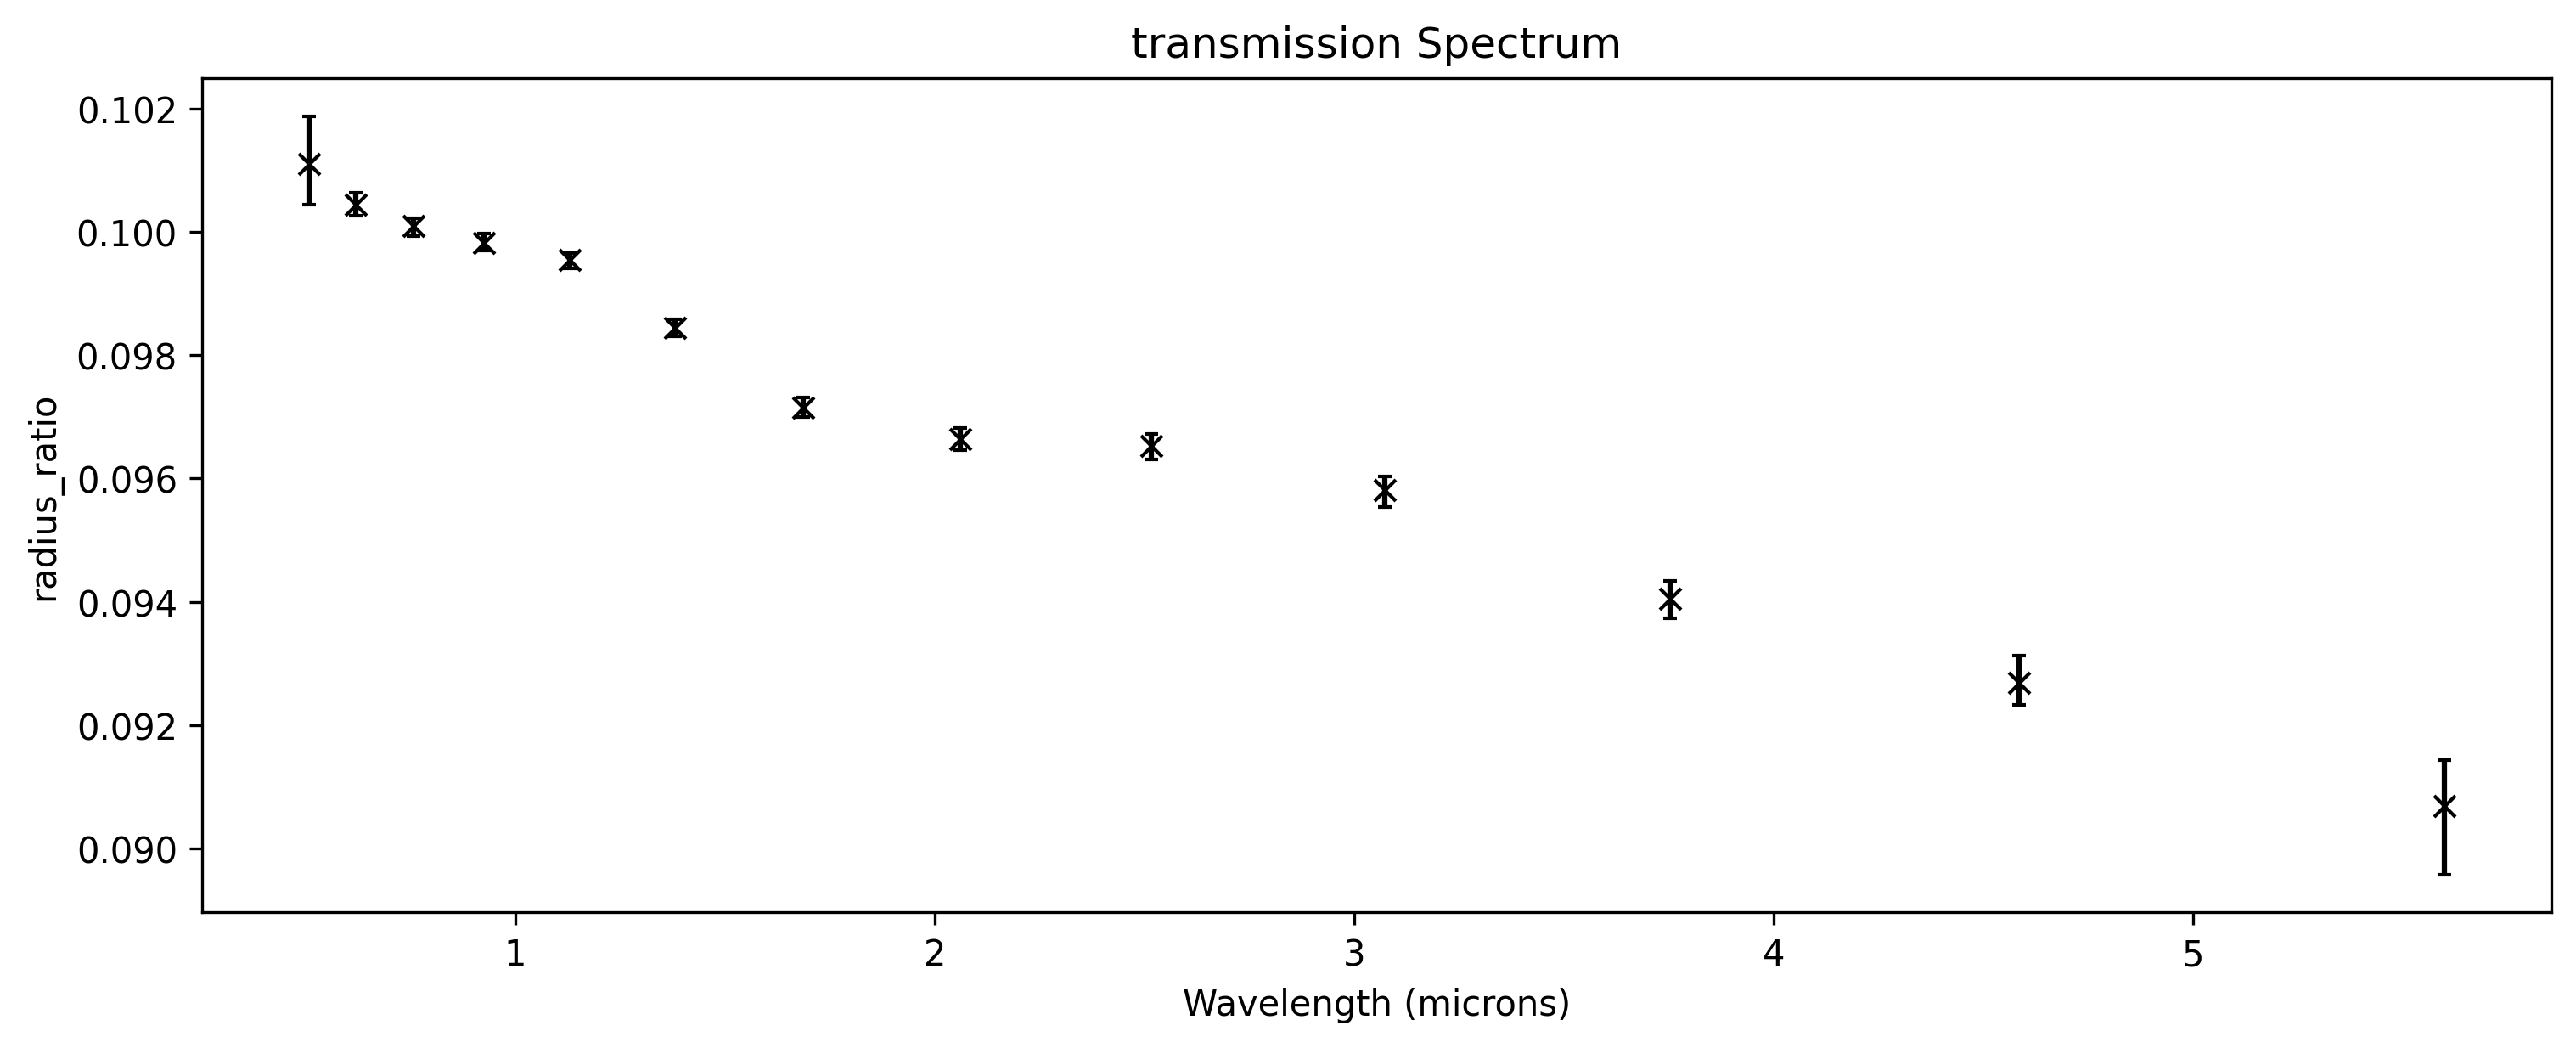

In [65]:
transspec = s.make_transmission_spectrum_table()
transspec.to_csv(f"{svname}_trans.csv")
s._chromatic_models['transitspot'].plot_spectrum()
plt.savefig(f"{svname}_transspec.png")
# plt.errorbar(data.wavelength.to_value('micron'), transspec['transitspot_radius_ratio'], xerr=[u_wave_errors, l_wave_errors])
# transspec.to_csv("R10_transspec.csv")
# plt.plot(
# transspec

### Extract spot contrast from model

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_{param}_neg_error"] = (
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_{param}_neg_error"] = (


NameError: name 'sr' is not defined

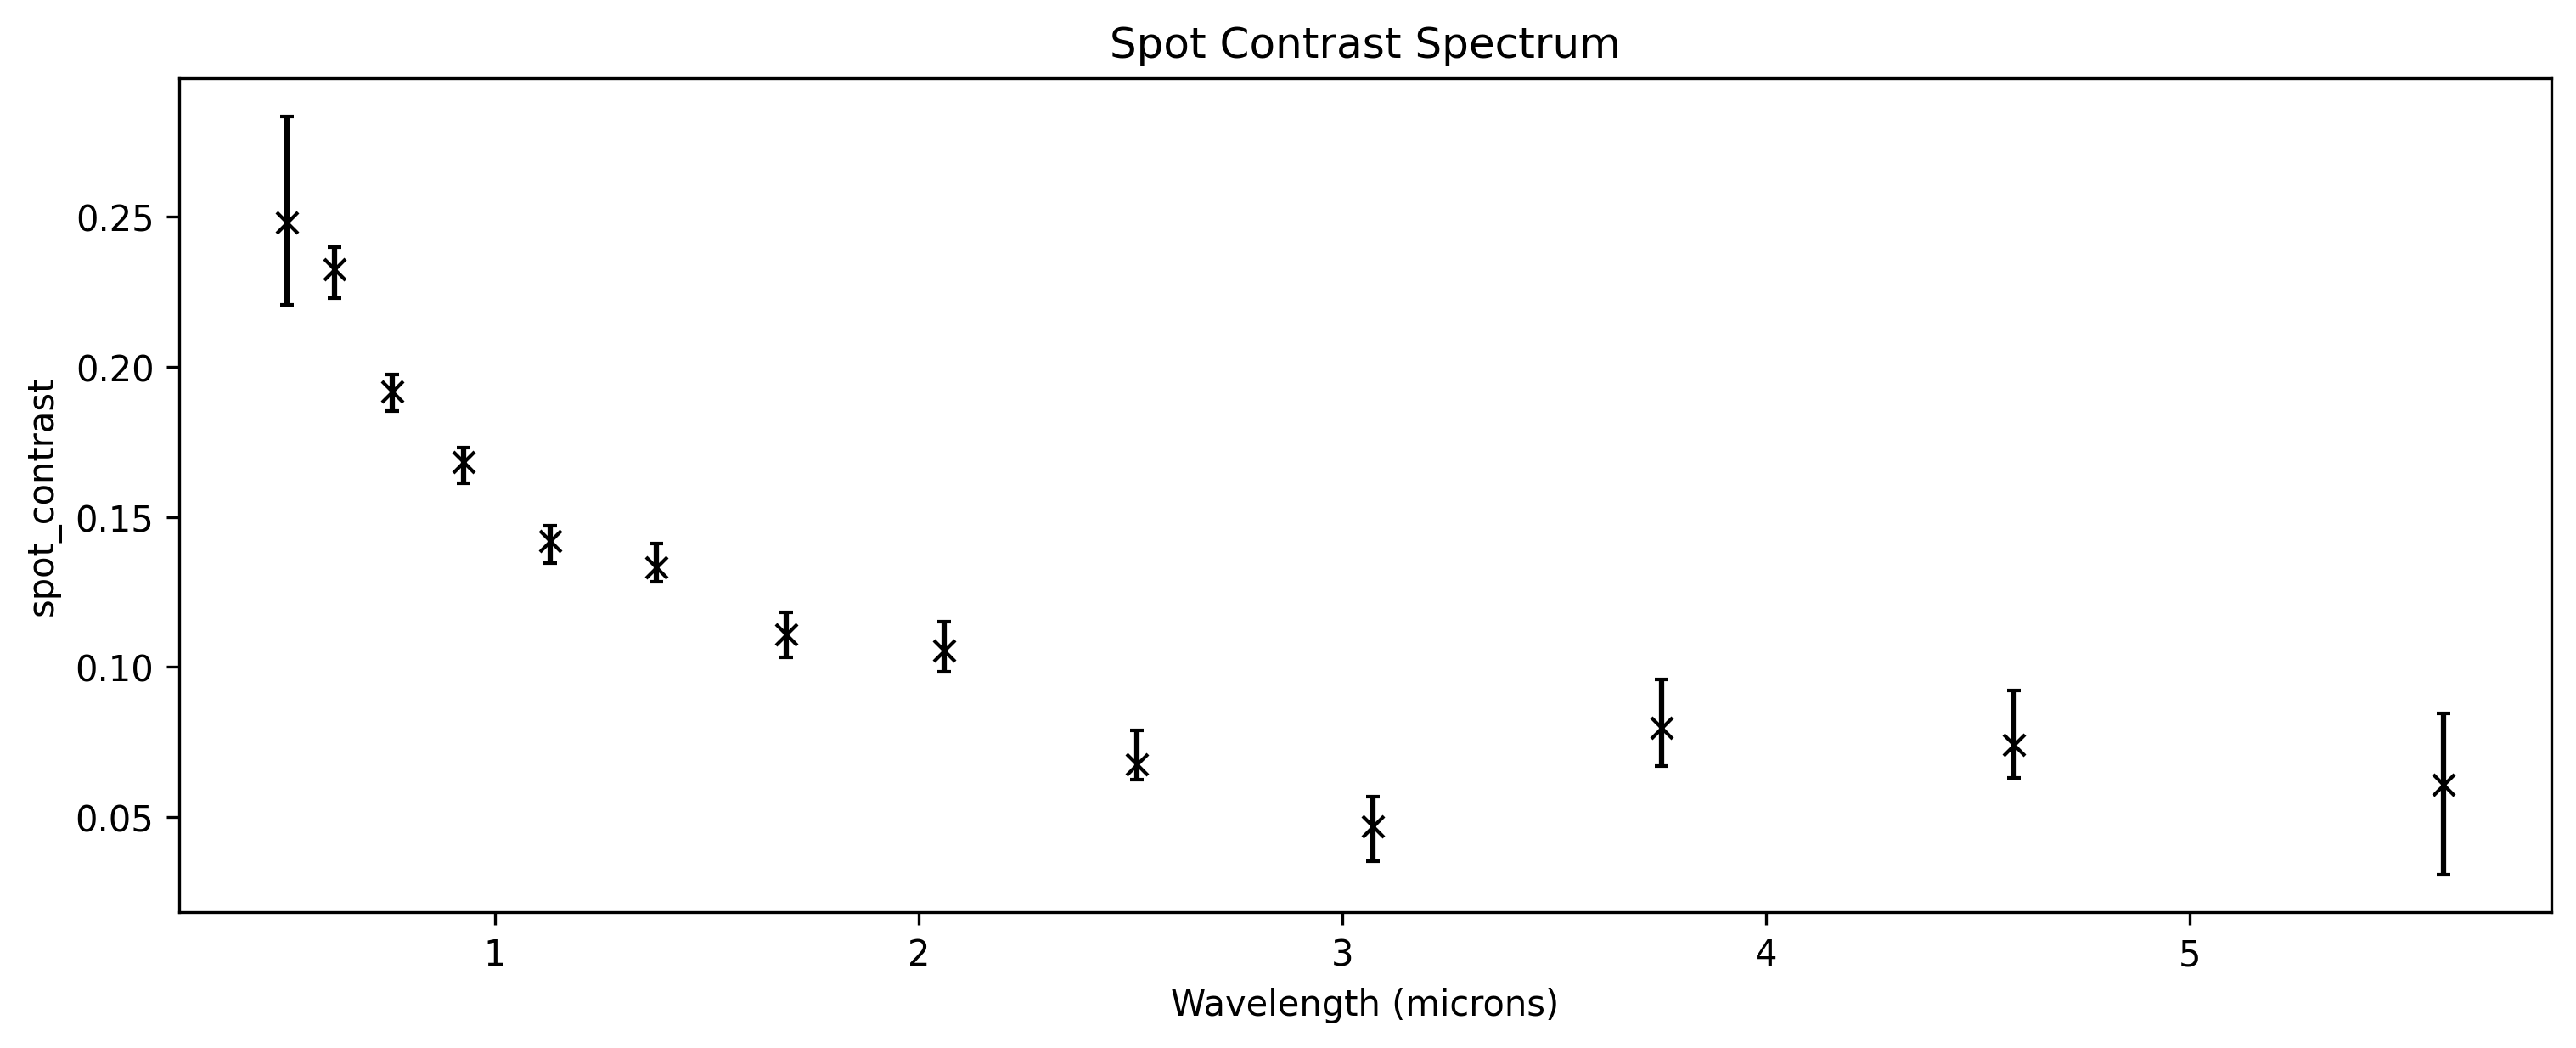

In [66]:
spot_contrast = s._chromatic_models['transitspot'].make_spectrum_table(param="spot_contrast")
spot_contrast.to_csv(f"{svname}_contrast.csv")

spot_contrast = s._chromatic_models['transitspot'].plot_spectrum(param="spot_contrast",name_of_spectrum='Spot Contrast') 

for spot_teff in np.linspace(5000, 5670, 10):
    contrast = get_spot_contrast(wavelengths=s.data.wavelength, star_teff=5670, spot_teff=spot_teff, spot_radii=[sr], logg=4.7, metallicity=0.0, visualize=False)
    plt.plot(s.data.wavelength, contrast, label=f"{round(spot_teff)}K", zorder=0, alpha=0.6)

plt.legend()
# spot_contrast = s._chromatic_models['transitspot'].make_spectrum_table(param="spot_contrast")
# plt.savefig("R10_spot_contrast.png")
# pd.DataFrame(spot_contrast).to_csv("R10_spot_contrast.csv")
# spot_contrast

### Plotting hack to get individual imshow components

In [37]:
data, models

NameError: name 'data' is not defined

In [67]:
transitmod = []
datas, models = s.choose_model_based_on_optimization_method()
data = s.data #datas[0]

for i in range(data.nwave):
    params = s._chromatic_models['transitspot'].extract_from_posteriors(s.summary, i=i)
    params['transitspot_spot_contrast'] = 0
    flux_model, sys = s._chromatic_models['transitspot'].setup_star_and_planet("transitspot_", 
                                                                               s._chromatic_models['transitspot'].method, 
                                                                               params, 
                                                                               s.data.time.to_value('d'), 
                                                                               [])
    transitmod.append(list(eval_in_model(flux_model, model=models[i])[0]))
transitmod = np.array(transitmod)
new_model_rainbow = data._create_copy()
new_model_rainbow = new_model_rainbow.attach_model(model=s.data_with_model.model/(np.transpose([s.data_with_model.model[:,0]]*data.ntime)), 
                               planet_model=transitmod/np.transpose([transitmod[:,0]]*data.ntime),
                              spot_model=(s.data_with_model.planet_model/transitmod) / np.transpose([s.data_with_model.planet_model[:,0]/transitmod[:,0]]*data.ntime),
                              systematics_model=s.data_with_model.systematics_model/np.transpose([s.data_with_model.systematics_model[:,0]]*data.ntime)
                                                  )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

In [68]:
new_model_rainbow.flux = new_model_rainbow.flux/np.mean(new_model_rainbow.flux[:,:50])

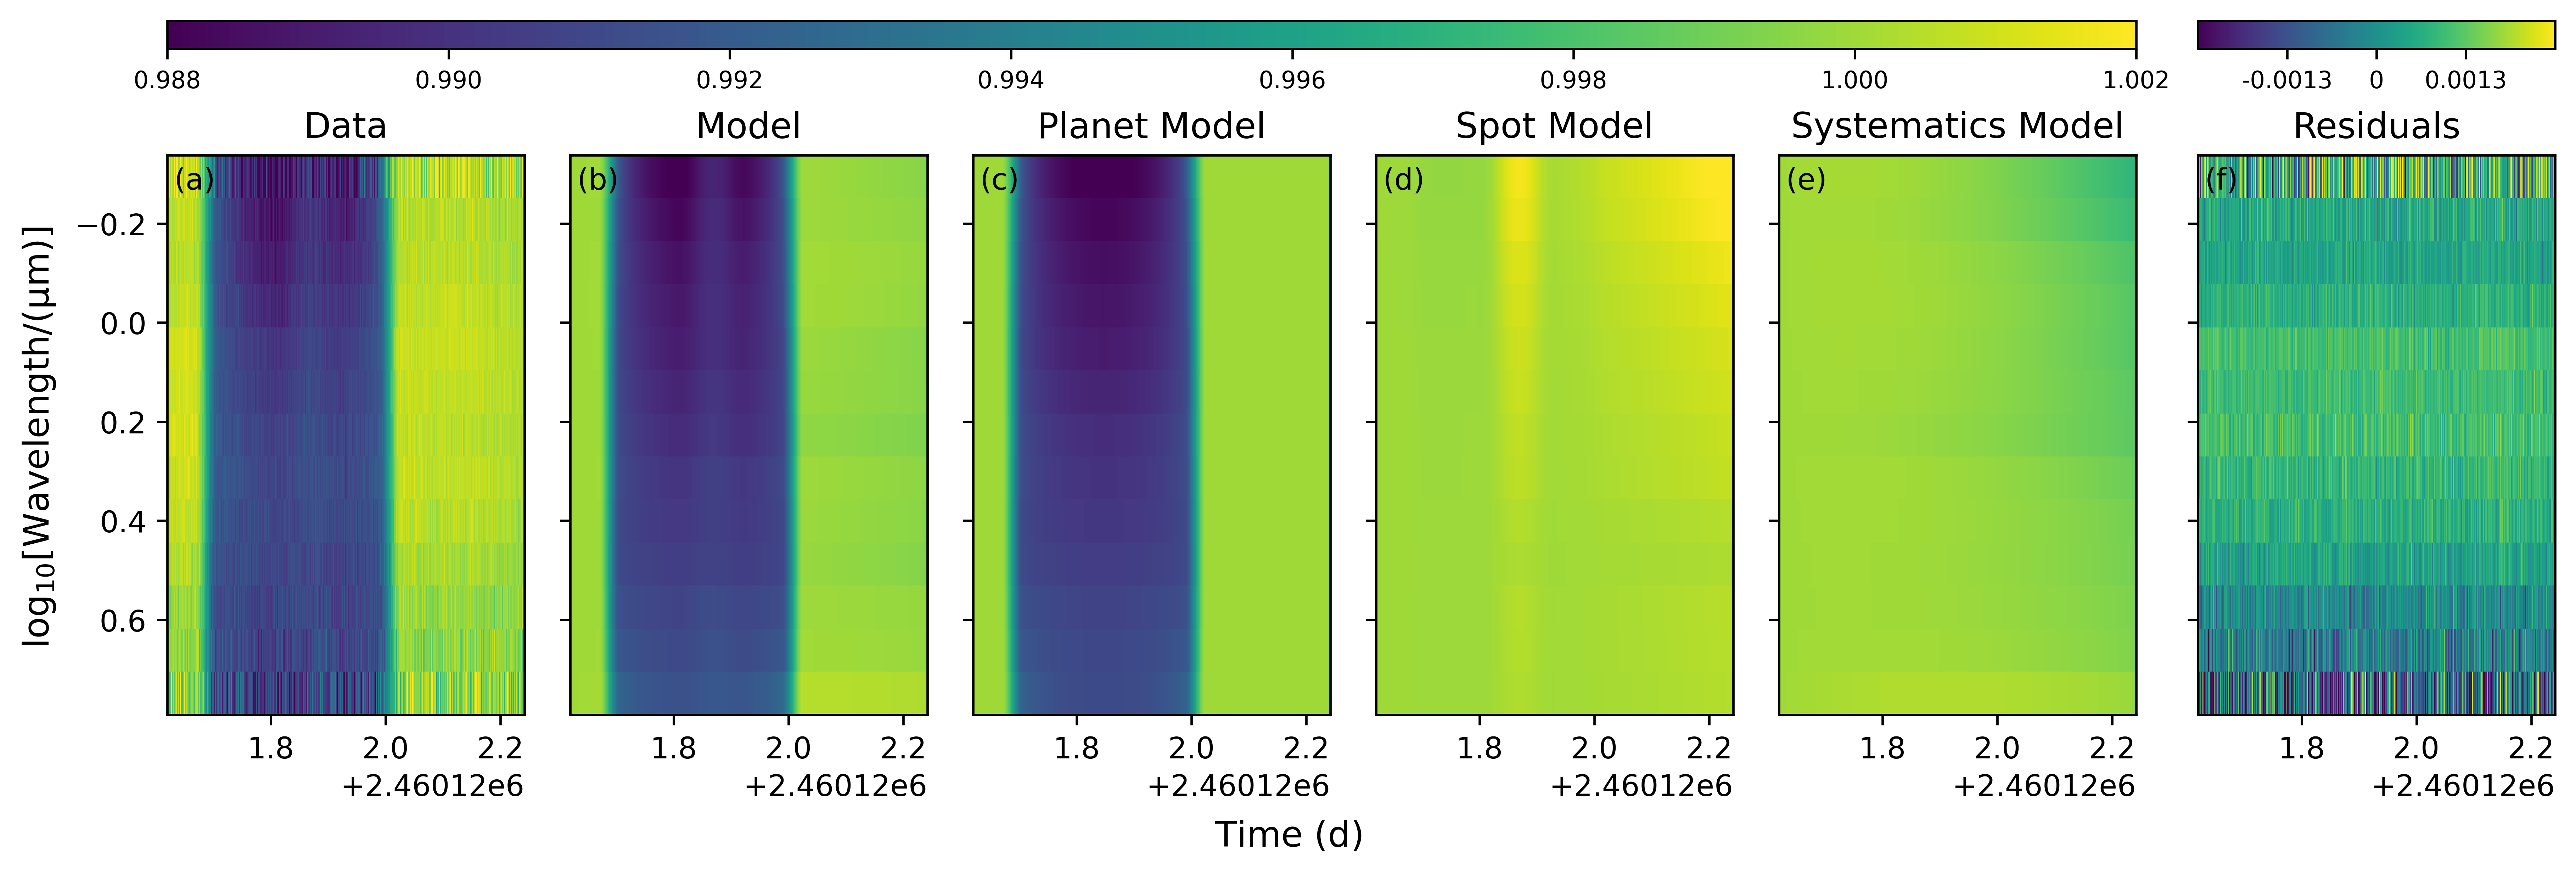

In [72]:
new_model_rainbow.imshow_with_models(models=['model','planet_model','spot_model', 'systematics_model'], 
                                     figsize=(12,4),
                                     vlimits_data=[0.988,1.002],
                                    vspan_residuals=0.0025)
plt.savefig(f"{svname}_imshow_all_mods.png")

In [155]:
spot_contrast = s._chromatic_models['transitspot'].make_spectrum_table(param="spot_contrast")
max(spot_contrast['transitspot_spot_contrast'].values)

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:1742: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_{param}_neg_error"] = (


0.2287463

In [75]:
s._chromatic_models['transitspot'].show_system(t=2460121.6)

In [74]:
s._chromatic_models['transitspot'].keplerian_system['w0'].primary.map.show()

AttributeError: 'TransitSpotModel' object has no attribute 'keplerian_system'

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


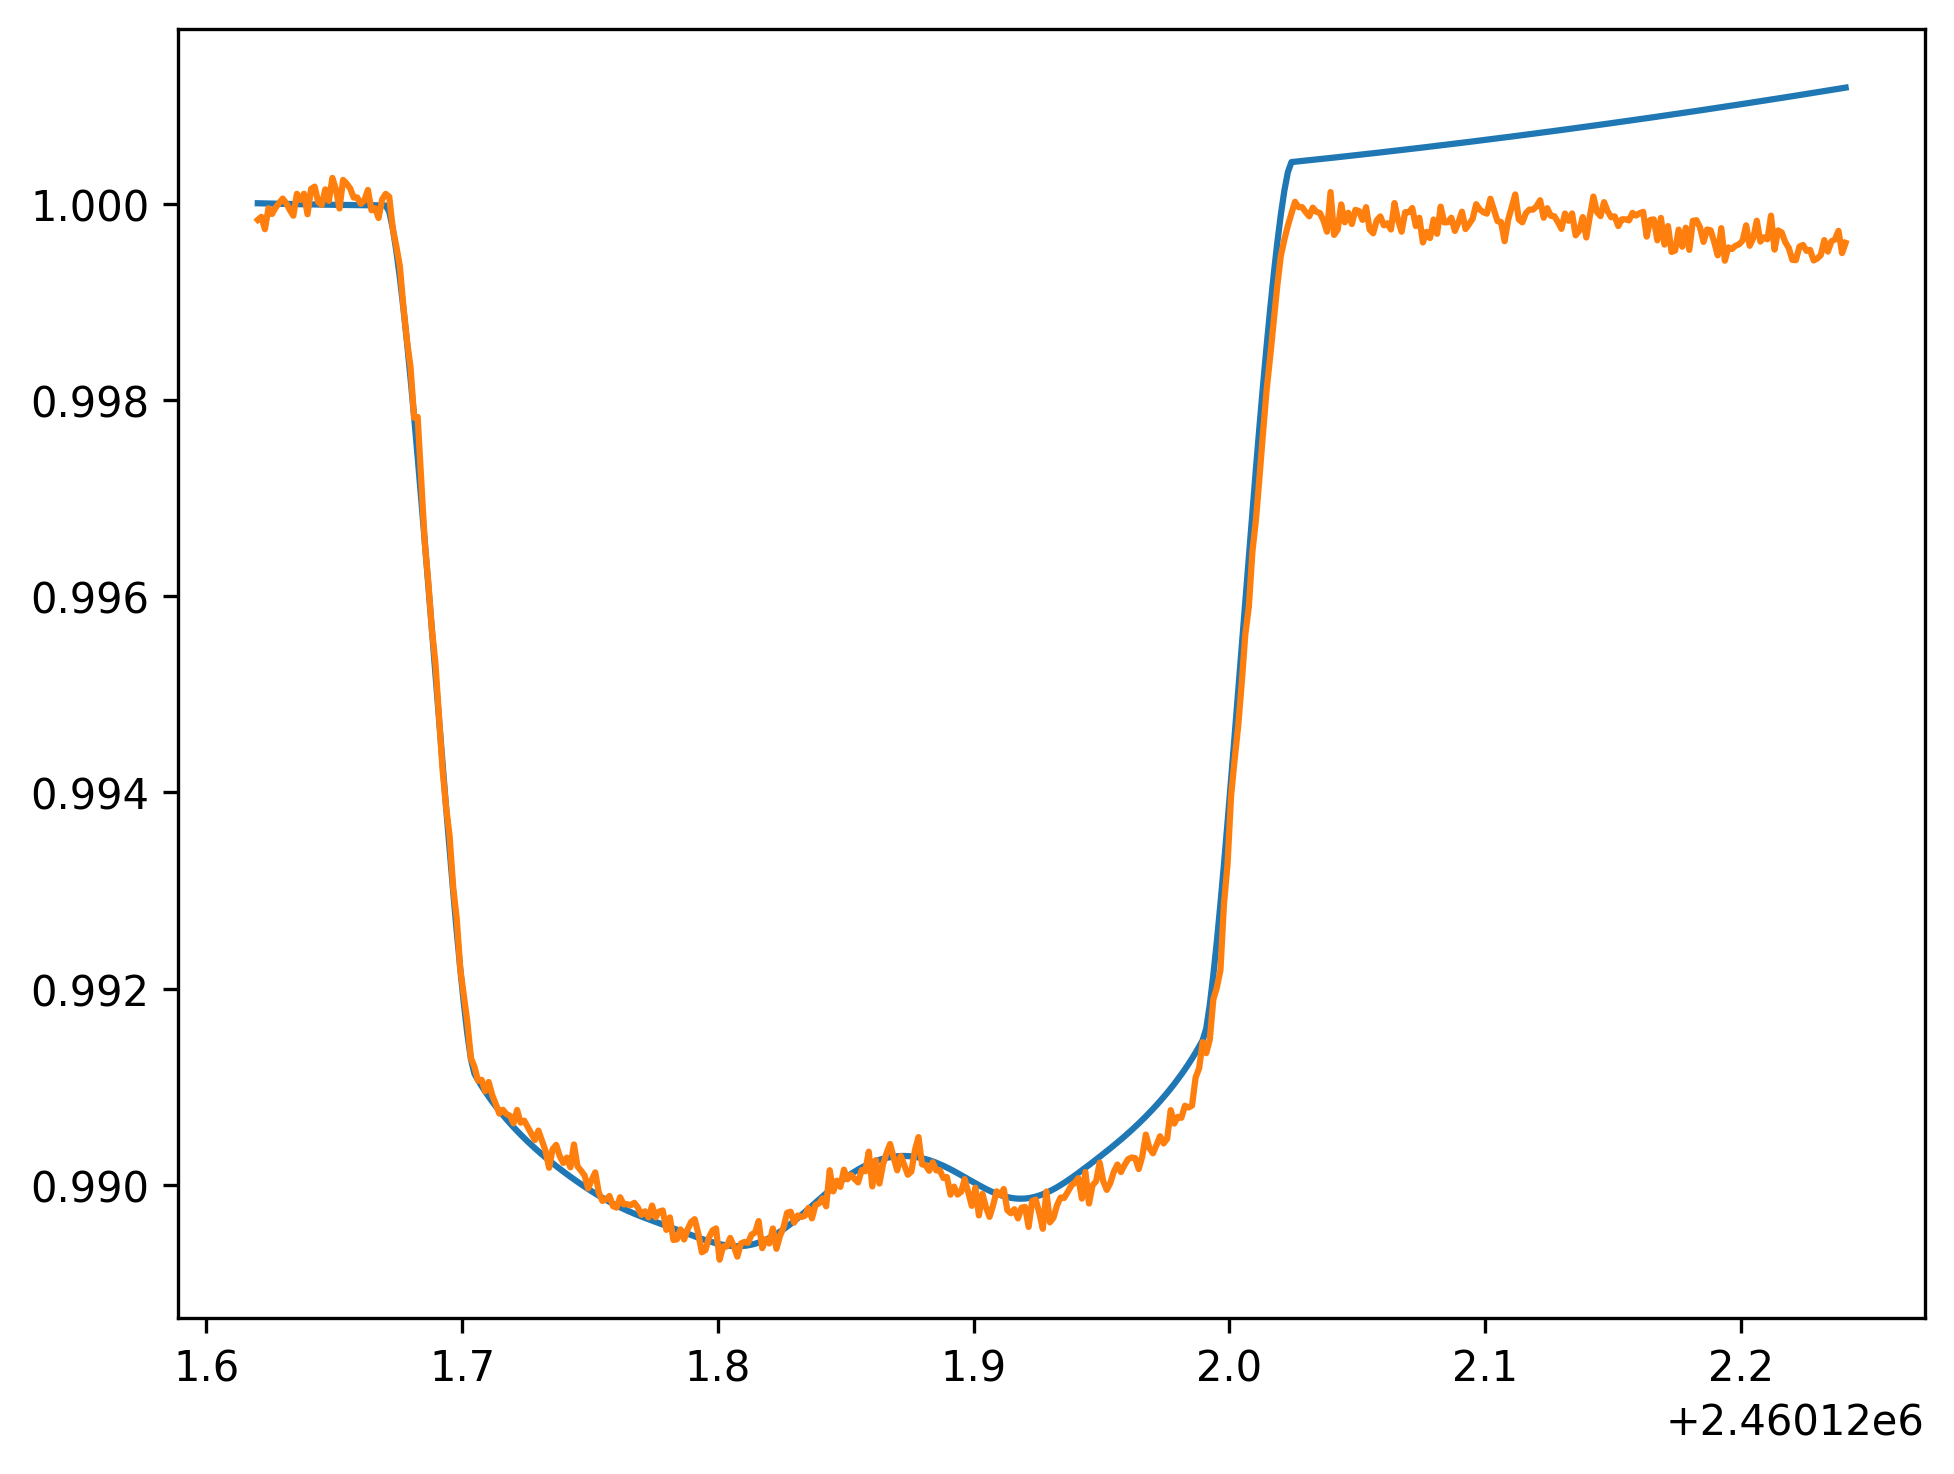

In [112]:
flux_system = eval_in_model(s._chromatic_models['transitspot'].keplerian_system['w0'].flux(s.data.time), model=s._pymc3_model)
plt.plot(s.data.time, flux_system/np.median(flux_system[:20]))
plt.plot(s.white_light.time, s.white_light.flux[0]/np.median(s.white_light.flux[0][:20]))

In [113]:
s.summary

mean        sd    hdi_16%    hdi_84%  \
transitspot_ms[0]                 0.990581  0.011488   0.978993   1.001253   
transitspot_inc[0]               89.872891  0.004439  89.868403  89.876946   
polynomial_p_0[0]                 1.011231  0.000773   1.010253   1.011826   
polynomial_p_1[0]                -0.000473  0.000025  -0.000493  -0.000440   
polynomial_p_2[0]                -0.000207  0.000010  -0.000216  -0.000195   
transitspot_rs[0]                 0.865267  0.003910   0.861936   0.869284   
transitspot_u[0, 0]               0.336345  0.014516   0.322088   0.349406   
transitspot_u[0, 1]              -0.020753  0.023477  -0.041762   0.002588   
transitspot_rp[0]                 9.284203  0.045520   9.247111   9.333504   
transitspot_spot_contrast[0]      0.146810  0.007655   0.140290   0.155874   
transitspot_spot_1_radius[0]     14.981099  0.323168  14.626243  15.240239   
transitspot_spot_1_latitude[0]   -2.518041  0.710741  -3.099518  -1.646144   
transitspot_spot_1_longitude[0]   6.542516  0.132618   6.431688   6.682449   
transitspot_radius_ratio[0]       0.098370  0.000094   0.098266   0.098448   

                                 mcse_mean       mcse_sd    ess_bulk  \
transitspot_ms[0]                 0.000396  2.805000e-04  897.635013   
transitspot_inc[0]                0.000214  1.510000e-04  432.440786   
polynomial_p_0[0]                 0.000090  6.410000e-05   75.430116   
polynomial_p_1[0]                 0.000003  2.000000e-06   80.649102   
polynomial_p_2[0]                 0.000001  7.000000e-07  100.242748   
transitspot_rs[0]                 0.000155  1.098000e-04  642.966774   
transitspot_u[0, 0]               0.000559  3.994000e-04  662.879700   
transitspot_u[0, 1]               0.000865  7.256000e-04  727.086017   
transitspot_rp[0]                 0.001864  1.319000e-03  598.551309   
transitspot_spot_contrast[0]      0.000810  5.744000e-04   89.326487   
transitspot_spot_1_radius[0]      0.026905  1.916950e-02  152.144593   
transitspot_spot_1_latitude[0]    0.052146  3.693100e-02  188.972458   
transitspot_spot_1_longitude[0]   0.005023  3.590100e-03  724.329212   
transitspot_radius_ratio[0]       0.000005  3.800000e-06  311.617891   

                                   ess_tail     r_hat  
transitspot_ms[0]                699.079677  1.002652  
transitspot_inc[0]               418.190904  1.007121  
polynomial_p_0[0]                 81.909050  1.024889  
polynomial_p_1[0]                 94.103373  1.024245  
polynomial_p_2[0]                145.219163  1.014848  
transitspot_rs[0]                795.382646  1.010657  
transitspot_u[0, 0]              599.286217  1.000535  
transitspot_u[0, 1]              650.454925  1.000457  
transitspot_rp[0]                740.583757  1.013507  
transitspot_spot_contrast[0]      80.195892  1.008445  
transitspot_spot_1_radius[0]     101.388635  1.020005  
transitspot_spot_1_latitude[0]   506.959630  1.020440  
transitspot_spot_1_longitude[0]  382.731562  1.000800  
transitspot_radius_ratio[0]      794.103335  1.011230

### Corner Plots

In [ ]:
# s.corner_plot()
import corner
for i, mod in enumerate(s._pymc3_model):
    try:
        with mod:
            # print(i,s.trace[i][0], mod)
            corner.corner(s.trace[i])
        plt.savefig(f"R10_{i}_corner.png")
    except Exception as e:
        print(e)
# plt.savefig("wlc_corner_with_poly.png")

In [ ]:
# s.data_with_model.animate_with_models()

In [8]:
def get_spot_contrast(wavelengths, star_teff=3180, spot_teff=2900, spot_radii=[0.29, 0.16, 0.09],
                      logg=4.97, metallicity=0.0, visualize=False):
    # phoenix = np.load("phoenix_photons_metallicity=0.0_R=100.npy", allow_pickle=True)
    pl = PHOENIXLibrary()
    S_star = pl.get_spectrum(temperature=star_teff, logg=logg, metallicity=metallicity,
                             wavelength=wavelengths, visualize=visualize)
    S_spot = pl.get_spectrum(temperature=spot_teff, logg=logg, metallicity=metallicity,
                             wavelength=wavelengths, visualize=visualize)

    f = 0
    for sr in spot_radii:
        f += sr ** 2
    print(f"Spot covering fraction = {f}")

    S_total = (f * S_spot[1]) + ((1 - f) * S_star[1])

    if visualize:
        plt.plot(S_star[0], S_star[1], label=f"Star (T={star_teff}K)")
        plt.plot(S_spot[0], S_spot[1], label=f"Spot (T={spot_teff}K)")
        plt.plot(wavelengths, S_total, 'k', alpha=0.3, label=f"Mixed Spectrum (f={f})")
        plt.plot(wavelengths, S_total, 'k.', label="Mixed Spectrum")

        plt.ylabel("Surface Flux [Photons / (s * m**2 * nm)]")
        plt.xlabel("Wavelength [micron]")
        plt.legend()

    contrast = (S_star[1] - S_spot[1]) / S_star[1]

    if visualize:
        plt.figure()
        plt.plot(wavelengths, contrast)
        plt.ylabel("Spot Contrast")
        plt.xlabel("Wavelength [micron]")

    return contrast

In [9]:
# lcs_1 = [(i*20, (i+1)*20) for i in range(0,4)]
a = [(0,20),(20,40),(40,60),(60,100),(100,120),(120,140)]
lcs = [(i*10, (i+1)*10) for i in range(14,43)]
a.extend(lcs)
a.extend([(430,444)])
a

[(0, 20),
 (20, 40),
 (40, 60),
 (60, 100),
 (100, 120),
 (120, 140),
 (140, 150),
 (150, 160),
 (160, 170),
 (170, 180),
 (180, 190),
 (190, 200),
 (200, 210),
 (210, 220),
 (220, 230),
 (230, 240),
 (240, 250),
 (250, 260),
 (260, 270),
 (270, 280),
 (280, 290),
 (290, 300),
 (300, 310),
 (310, 320),
 (320, 330),
 (330, 340),
 (340, 350),
 (350, 360),
 (360, 370),
 (370, 380),
 (380, 390),
 (390, 400),
 (400, 410),
 (410, 420),
 (420, 430),
 (430, 444)]

In [10]:
tspec_all, scont_all = [],[]
for (i,j) in a:
    print(i,j)
    # s = np.load(f"native_res/k51_{i}_{j}.chromfit.npy", allow_pickle=True)
    # transspec = s.make_transmission_spectrum_table()
    transspec = pd.read_csv(f"native_res/k51_{i}_{j}_trans.csv", index_col=0)
    tspec_all.append(transspec)

    spot_contrast = pd.read_csv(f"native_res/k51_{i}_{j}_contrast.csv", index_col=0)#s._chromatic_models['transitspot'].make_spectrum_table(param="spot_contrast")
    scont_all.append(spot_contrast)
    # spot_contrast.to_csv(f"native_res/k51_{i}_{j}_contrast.csv")
# svname = f"native_res/k51_{60}_{100}"

0 20
20 40
40 60
60 100
100 120
120 140
140 150
150 160
160 170
170 180
180 190
190 200
200 210
210 220
220 230
230 240
240 250
250 260
260 270
270 280
280 290
290 300
300 310
310 320
320 330
330 340
340 350
350 360
360 370
370 380
380 390
390 400
400 410
410 420
420 430
430 444


In [11]:
tspec_all_df = pd.concat(tspec_all)

In [12]:
tspec_all_df

wavelength  transitspot_radius_ratio  \
w0   0.5079671740531921 micron                  0.102832   
w1   0.5105938911437988 micron                  0.101694   
w2   0.5132818222045898 micron                  0.106820   
w3   0.5159979462623596 micron                  0.099886   
w4   0.5187652111053467 micron                  0.106643   
..                         ...                       ...   
w9    5.326274871826172 micron                  0.100149   
w10   5.333590984344482 micron                  0.088961   
w11   5.340895652770996 micron                  0.091287   
w12   5.348189353942871 micron                  0.100740   
w13   5.355472087860107 micron                  0.094642   

     transitspot_radius_ratio_neg_error  transitspot_radius_ratio_pos_error  
w0                             0.005004                            0.004045  
w1                             0.004770                            0.004840  
w2                             0.004302                            0.003954  
w3                             0.004056                            0.004562  
w4                             0.003826                            0.003393  
..                                  ...                                 ...  
w9                             0.003170                            0.003755  
w10                            0.004119                            0.003503  
w11                            0.003799                            0.003913  
w12                            0.003973                            0.003704  
w13                            0.003807                            0.003964  

[444 rows x 4 columns]

In [13]:
wave = [np.float(t.split(" ")[0]) for t in tspec_all_df['wavelength'].values]#[t.to_value("micron") for t in tspec_all_df['wavelength'].values]

/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/2991832093.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  wave = [np.float(t.split(" ")[0]) for t in tspec_all_df['wavelength'].values]#[t.to_value("micron") for t in tspec_all_df['wavelength'].values]


In [14]:
tspec_all_df['wavelength'] = wave

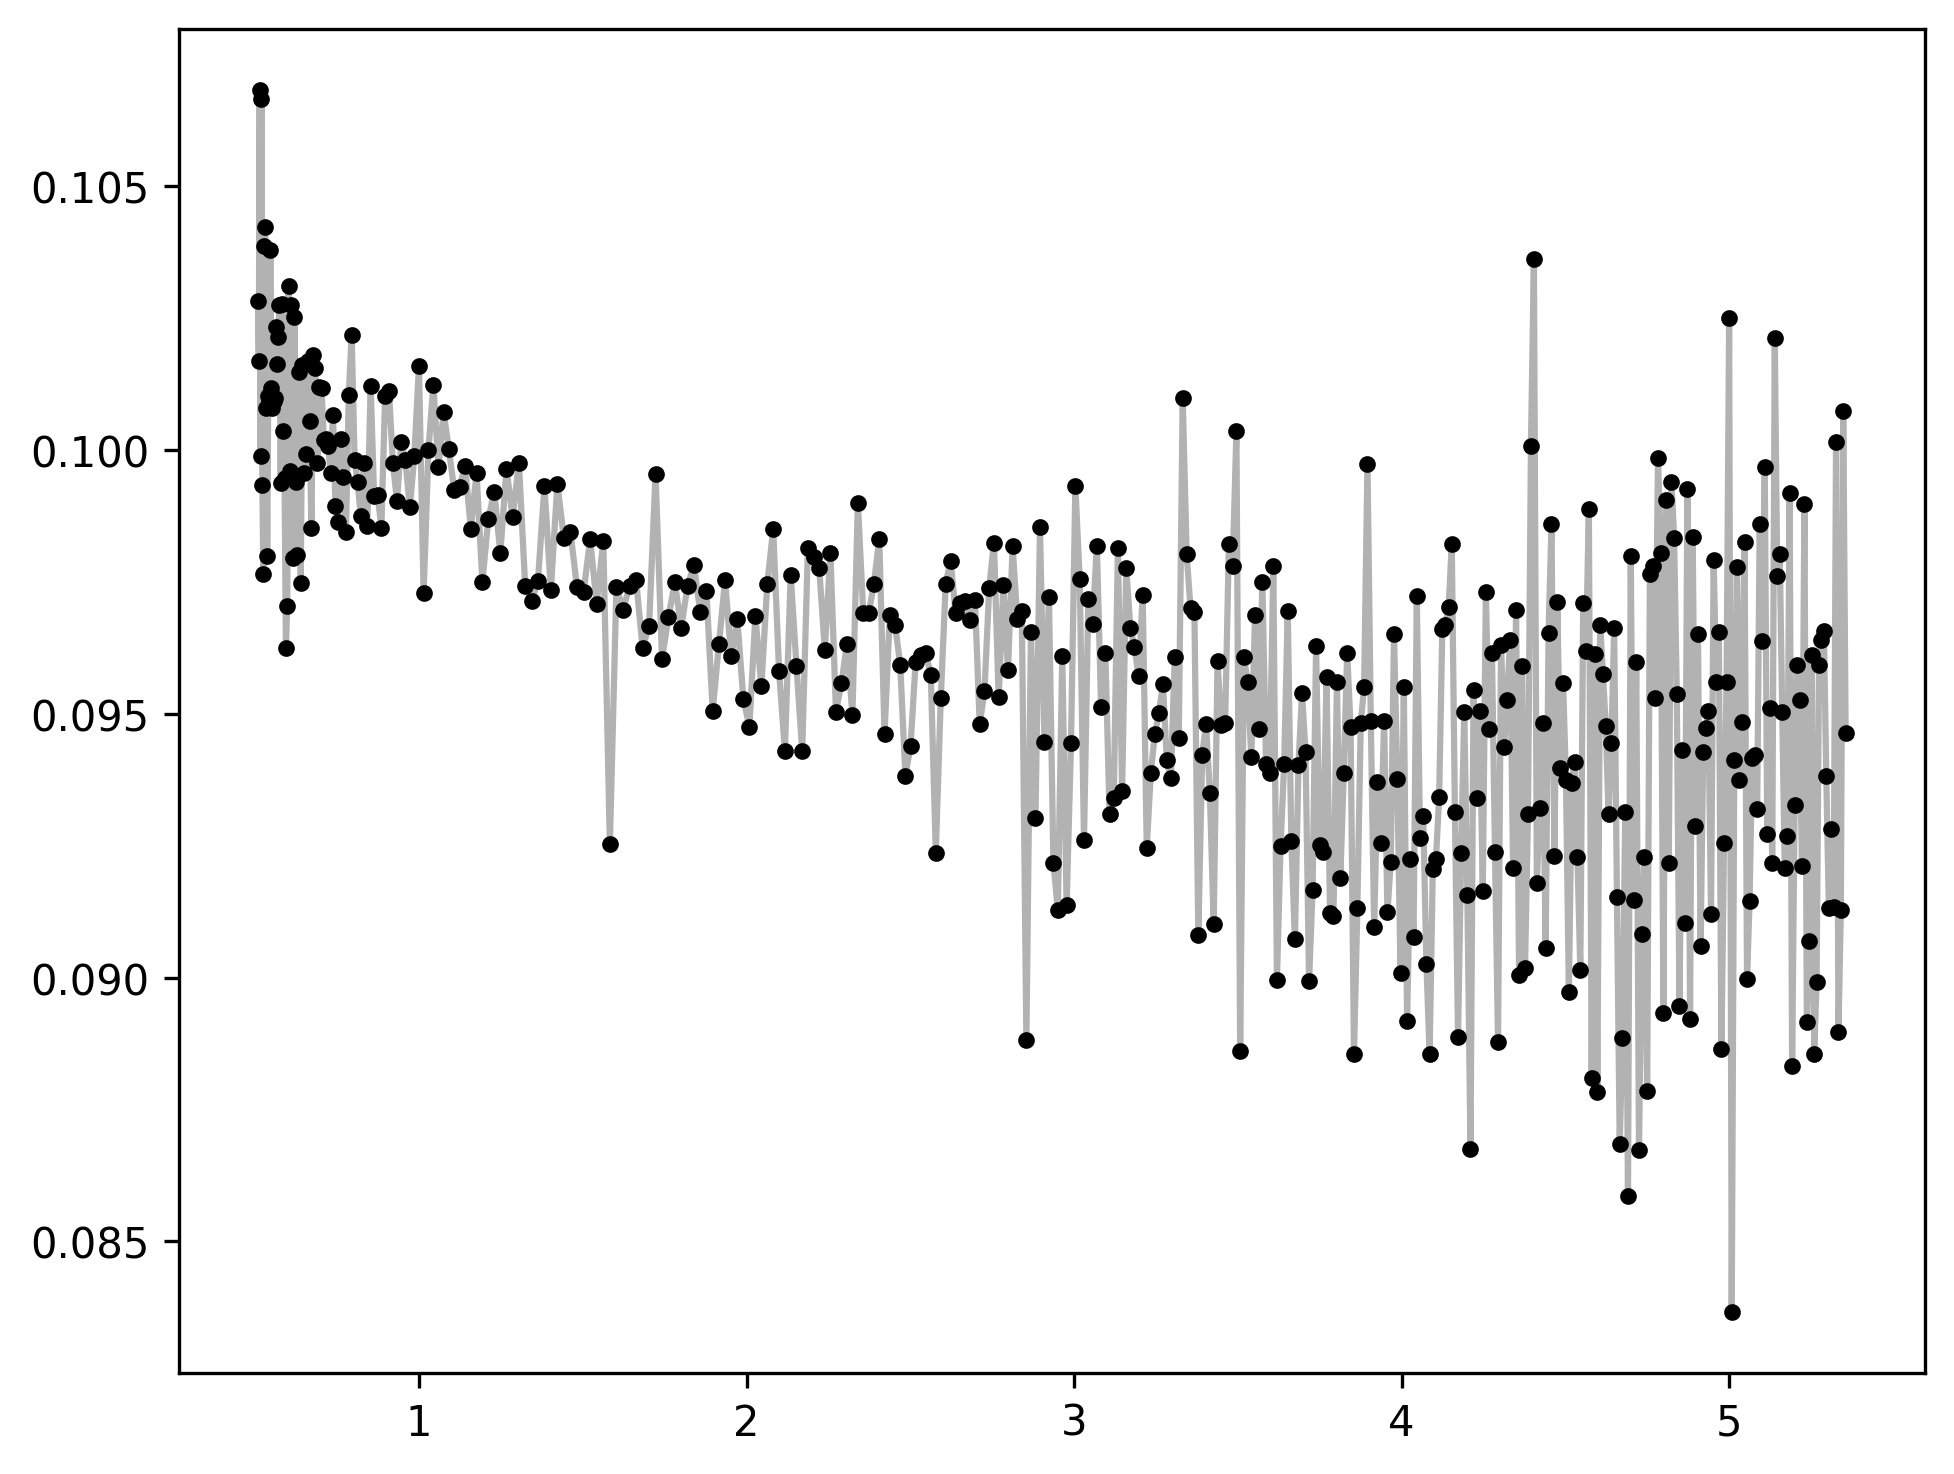

In [15]:
plt.plot(tspec_all_df['wavelength'].values, tspec_all_df['transitspot_radius_ratio'].values,'k-', alpha=0.3)
plt.plot(tspec_all_df['wavelength'].values, tspec_all_df['transitspot_radius_ratio'].values,'k.')

In [16]:
# tspec_r10 =  pd.read_csv("R10/ydeg26/k51_0_13_trans.csv", index_col=0) #pd.read_csv("R10_transspec.csv", index_col=0)
# tspec_r10['wavelength'] = [np.float(t.split(" ")[0]) for t in tspec_r10['wavelength'].values]
tspec_r5 = pd.read_csv("R5/k51_R5__trans.csv", index_col=0)
tspec_r5['wavelength'] = [np.float(t.split(" ")[0]) for t in tspec_r5['wavelength'].values]

tspec_r5_y26 = pd.read_csv("R5/ydeg26/k51_0_13_trans.csv", index_col=0)
tspec_r5_y26['wavelength'] = [np.float(t.split(" ")[0]) for t in tspec_r5_y26['wavelength'].values]

/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/3155429892.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tspec_r5['wavelength'] = [np.float(t.split(" ")[0]) for t in tspec_r5['wavelength'].values]
/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/3155429892.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [17]:
from chromatic import bintogrid, bintoR
unc = np.mean([tspec_all_df['transitspot_radius_ratio_neg_error'].values,tspec_all_df['transitspot_radius_ratio_pos_error'].values], axis=0)
binned_tspec_r10 = bintoR(x=tspec_all_df['wavelength'].values, y=tspec_all_df['transitspot_radius_ratio'].values,
       unc=unc,R=10)
binned_tspec_r5 = bintoR(x=tspec_all_df['wavelength'].values, y=tspec_all_df['transitspot_radius_ratio'].values,
       unc=unc,R=5)
binned_tspec_r15 = bintoR(x=tspec_all_df['wavelength'].values, y=tspec_all_df['transitspot_radius_ratio'].values,
       unc=unc,R=15)
binned_tspec_r10

{'x': array([0.50796717, 0.56139055, 0.62043251, 0.68568396, 0.75779798,
        0.83749628, 0.92557654, 1.02292027, 1.13050174, 1.24939764,
        1.38079794, 1.52601773, 1.68651041, 1.86388226, 2.05990847,
        2.27655093, 2.51597788, 2.78058559, 3.07302233, 3.39621491,
        3.75339795, 4.14814625, 4.5844106 , 5.06655728, 5.59941176]),
 'x_edge_lower': array([0.48319332, 0.53401121, 0.59017366, 0.65224276, 0.72083973,
        0.79665111, 0.88043564, 0.97303186, 1.07536652, 1.1884638 ,
        1.31345563, 1.45159296, 1.60425833, 1.77297965, 1.95944555,
        2.16552223, 2.39327219, 2.64497483, 2.92314926, 3.23057955,
        3.57034257, 3.94583877, 4.36082626, 4.81945836, 5.32632522]),
 'x_edge_upper': array([0.53401121, 0.59017366, 0.65224276, 0.72083973, 0.79665111,
        0.88043564, 0.97303186, 1.07536652, 1.1884638 , 1.31345563,
        1.45159296, 1.60425833, 1.77297965, 1.95944555, 2.16552223,
        2.39327219, 2.64497483, 2.92314926, 3.23057955, 3.57034257,
       

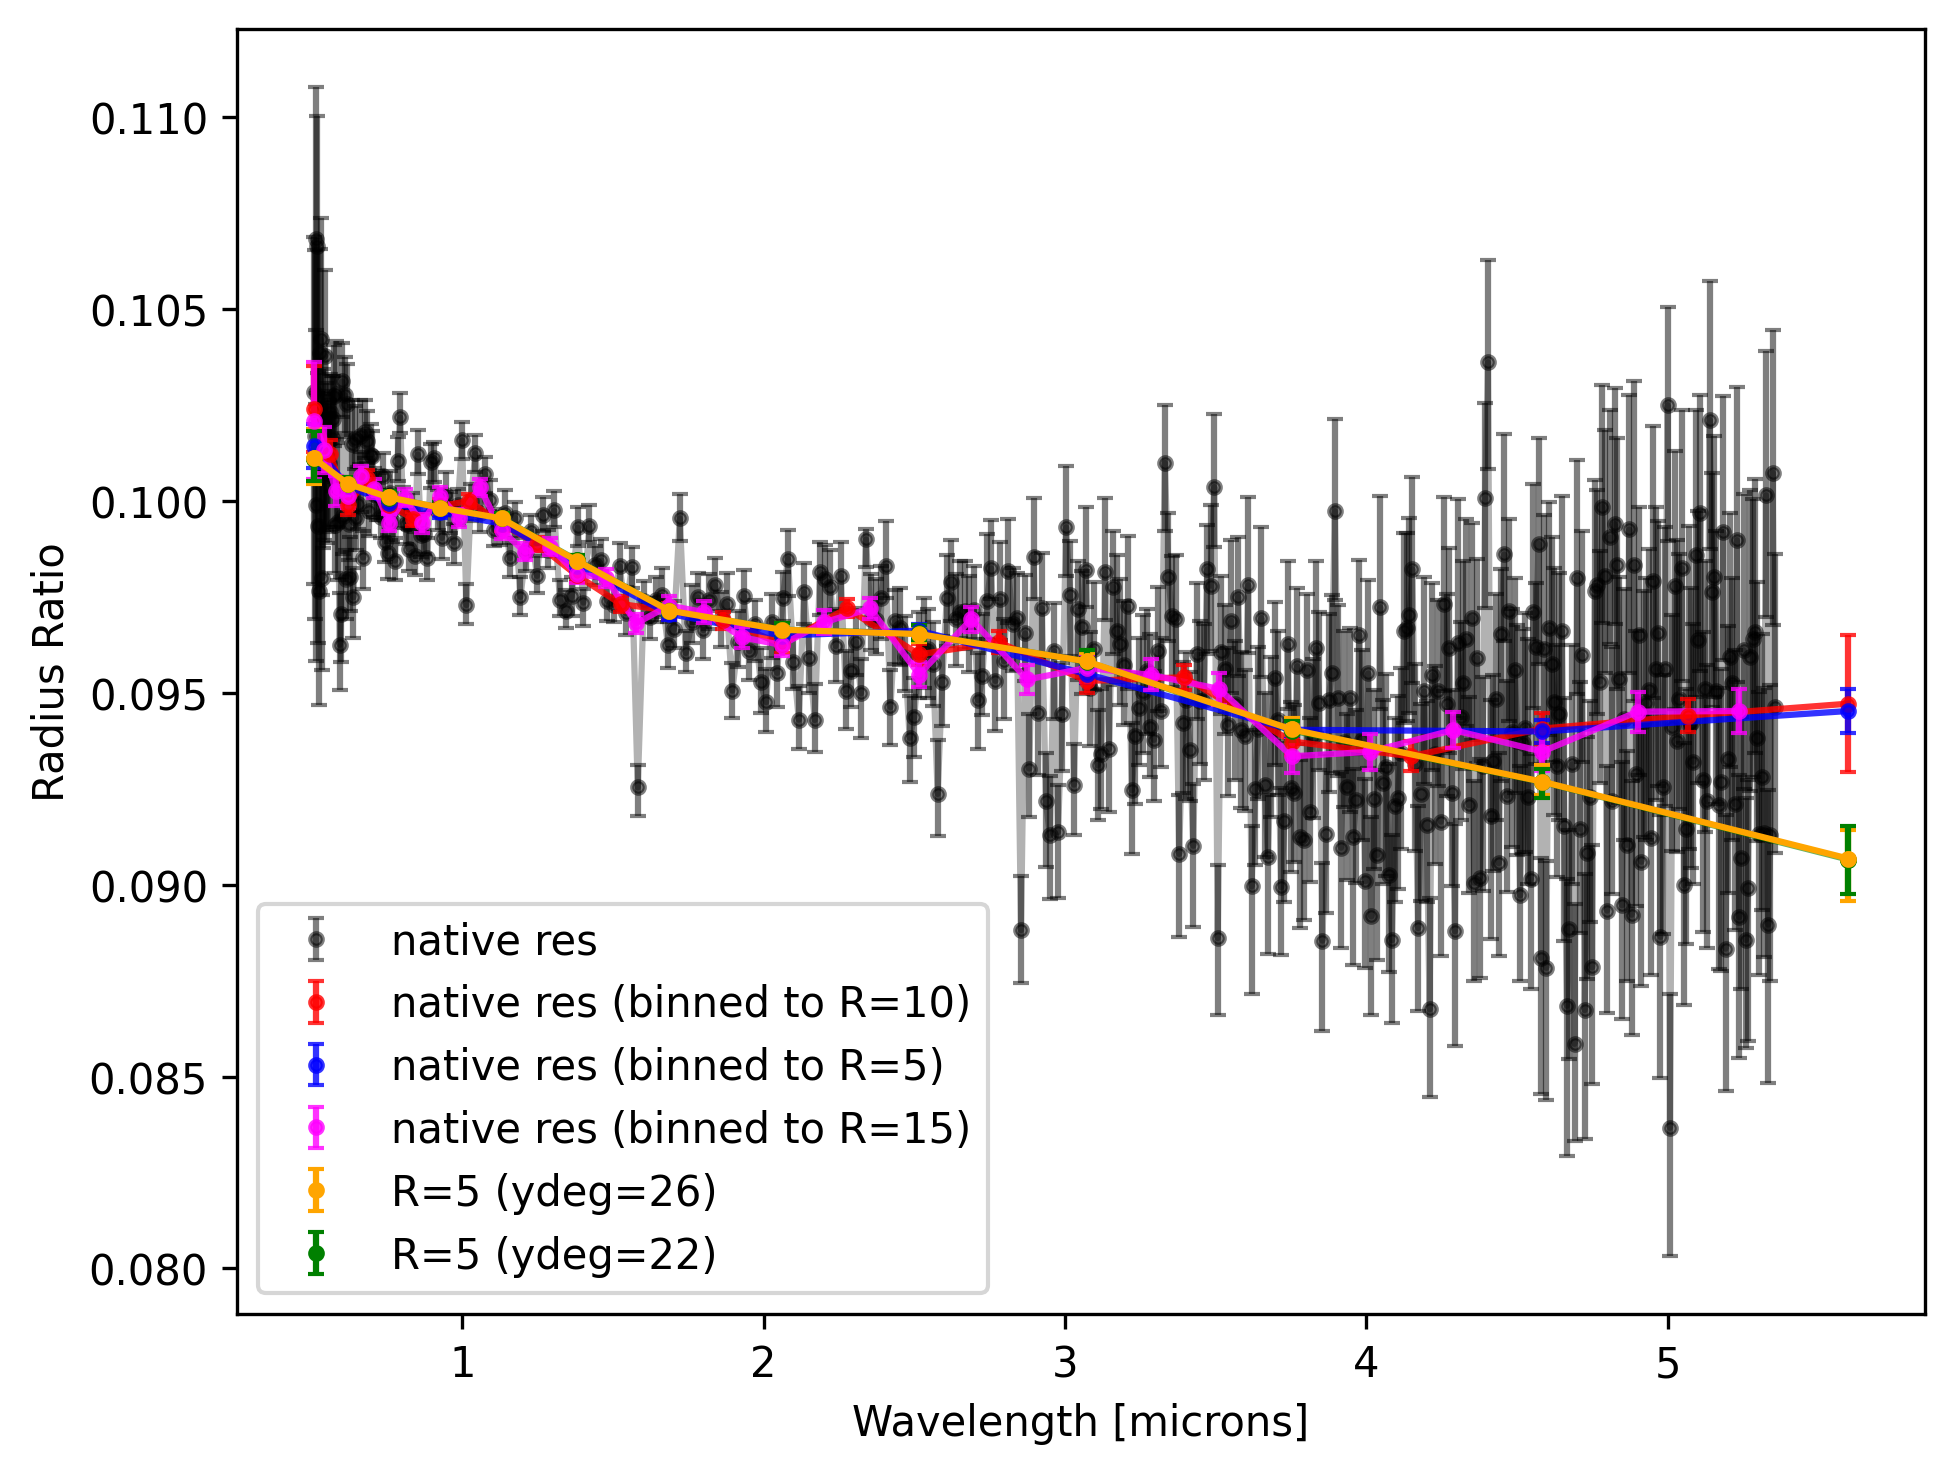

In [18]:
plt.plot(tspec_all_df['wavelength'].values, tspec_all_df['transitspot_radius_ratio'].values,'k-', alpha=0.3, zorder=0)
plt.errorbar(tspec_all_df['wavelength'].values, 
             tspec_all_df['transitspot_radius_ratio'].values,
             yerr = [tspec_all_df['transitspot_radius_ratio_neg_error'].values,tspec_all_df['transitspot_radius_ratio_pos_error'].values],
             fmt='k.', alpha=0.5, label="native res",  capsize=2, zorder=1)

plt.plot(binned_tspec_r10['x'], binned_tspec_r10['y'],'r-', alpha=0.8, zorder=10)
plt.errorbar(binned_tspec_r10['x'], 
             binned_tspec_r10['y'],
             yerr = binned_tspec_r10['uncertainty'],
             fmt='r.', alpha=0.8, label="native res (binned to R=10)",  capsize=2, zorder=10)
plt.plot(binned_tspec_r5['x'], binned_tspec_r5['y'],'b-', alpha=0.8, zorder=10)
plt.errorbar(binned_tspec_r5['x'], 
             binned_tspec_r5['y'],
             yerr = binned_tspec_r5['uncertainty'],
             fmt='b.', alpha=0.8, label="native res (binned to R=5)",  capsize=2, zorder=10)
plt.plot(binned_tspec_r15['x'], binned_tspec_r15['y'],'-', color='magenta', alpha=0.8, zorder=10)
plt.errorbar(binned_tspec_r15['x'], 
             binned_tspec_r15['y'],
             yerr = binned_tspec_r15['uncertainty'],
             fmt='.', color='magenta', alpha=0.8, label="native res (binned to R=15)",  capsize=2, zorder=10)


plt.plot(tspec_r5_y26['wavelength'].values, tspec_r5_y26['transitspot_radius_ratio'].values,'-', color='orange', alpha=1.0, zorder=50)
plt.plot(tspec_r5_y26['wavelength'].values, tspec_r5_y26['transitspot_radius_ratio'].values,'.', color='orange', zorder=50)
plt.errorbar(tspec_r5_y26['wavelength'].values, 
             tspec_r5_y26['transitspot_radius_ratio'].values,
             yerr = [tspec_r5_y26['transitspot_radius_ratio_neg_error'].values,tspec_r5_y26['transitspot_radius_ratio_pos_error'].values],
             fmt='.', color='orange', alpha=1.0, label="R=5 (ydeg=26)", capsize=2, zorder=10)

plt.plot(tspec_r5['wavelength'].values, tspec_r5['transitspot_radius_ratio'].values,'-', color='g', alpha=0.6)
plt.plot(tspec_r5['wavelength'].values, tspec_r5['transitspot_radius_ratio'].values,'.', color='g')
plt.errorbar(tspec_r5['wavelength'].values, 
             tspec_r5['transitspot_radius_ratio'].values,
             yerr = [tspec_r5['transitspot_radius_ratio_neg_error'].values,tspec_r5['transitspot_radius_ratio_pos_error'].values],
             fmt='.', color='g', alpha=1.0, label="R=5 (ydeg=22)", capsize=2, zorder=10)

plt.ylabel("Radius Ratio")
plt.xlabel("Wavelength [microns]")
# plt.xlim(0.45,2.5)
plt.legend()
plt.savefig("transspec_comparison_native.png")

In [19]:
tspec_all_df_to_save = tspec_all_df.reset_index(drop=True)
tspec_all_df_to_save.to_csv("trans_spec_native.csv")

In [20]:
scont_all_df = pd.concat(scont_all)

In [21]:
scont_all_df['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_all_df['wavelength'].values]#[t.to_value("micron") for t in scont_all_df['wavelength'].values]

/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/1105933480.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scont_all_df['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_all_df['wavelength'].values]#[t.to_value("micron") for t in scont_all_df['wavelength'].values]


In [22]:
scont_all_df

wavelength  transitspot_spot_contrast  \
w0     0.507967                   0.104264   
w1     0.510594                   0.071557   
w2     0.513282                   0.110124   
w3     0.515998                   0.215965   
w4     0.518765                   0.075166   
..          ...                        ...   
w9     5.326275                   0.160013   
w10    5.333591                   0.149958   
w11    5.340896                   0.095011   
w12    5.348189                   0.102963   
w13    5.355472                   0.064427   

     transitspot_spot_contrast_neg_error  transitspot_spot_contrast_pos_error  
w0                              0.095459                             0.033760  
w1                              0.070248                             0.016831  
w2                              0.088383                             0.041118  
w3                              0.120109                             0.096713  
w4                              0.075033                             0.019789  
..                                   ...                                  ...  
w9                              0.101850                             0.050913  
w10                             0.126644                             0.042177  
w11                             0.090675                             0.026754  
w12                             0.101828                             0.026274  
w13                             0.063988                             0.017865  

[444 rows x 4 columns]

In [23]:
# scont_r10 = pd.read_csv("R10_spot_contrast.csv", index_col=0)
# # scont_r10['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_r10['wavelength'].values]
scont_r10, scont_r10_err_neg, scont_r10_err_pos = [],[],[]
summary = np.load("R10_summary_with_poly.npy", allow_pickle=True)
for s in summary:
    scont_r10.append(s['mean']['transitspot_spot_contrast[0]'])
    scont_r10_err_neg.append((s['mean']-s['hdi_16%'])['transitspot_spot_contrast[0]'])
    scont_r10_err_pos.append((s['hdi_84%']-s['mean'])['transitspot_spot_contrast[0]'])
# scont_r10

In [24]:
scont_r5 = pd.read_csv("R5/k51_R5__contrast.csv", index_col=0)
scont_r5['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_r5['wavelength'].values]
scont_r5

scont_r5_y26 = pd.read_csv("R5/ydeg26/k51_0_13_contrast.csv", index_col=0)
scont_r5_y26['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_r5_y26['wavelength'].values]

/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/2966450796.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scont_r5['wavelength'] = [np.float(t.split(" ")[0]) for t in scont_r5['wavelength'].values]
/var/folders/hy/dkcmd9g50gzf2r2ccgybcp4c0000gn/T/ipykernel_9879/2966450796.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [25]:
unc = np.mean([scont_all_df['transitspot_spot_contrast_neg_error'].values,scont_all_df['transitspot_spot_contrast_pos_error'].values], axis=0)
binned_scont_r10 = bintoR(x=scont_all_df['wavelength'].values, y=scont_all_df['transitspot_spot_contrast'].values,
       unc=unc,R=10)
binned_scont_r5 = bintoR(x=scont_all_df['wavelength'].values, y=scont_all_df['transitspot_spot_contrast'].values,
       unc=unc,R=5)
binned_scont_r15 = bintoR(x=scont_all_df['wavelength'].values, y=scont_all_df['transitspot_spot_contrast'].values,
       unc=unc,R=15)

Spot covering fraction = 0.06681287071932408
Spot covering fraction = 0.06681287071932408
Spot covering fraction = 0.06681287071932408
Spot covering fraction = 0.06681287071932408
Spot covering fraction = 0.06681287071932408
Spot covering fraction = 0.06681287071932408


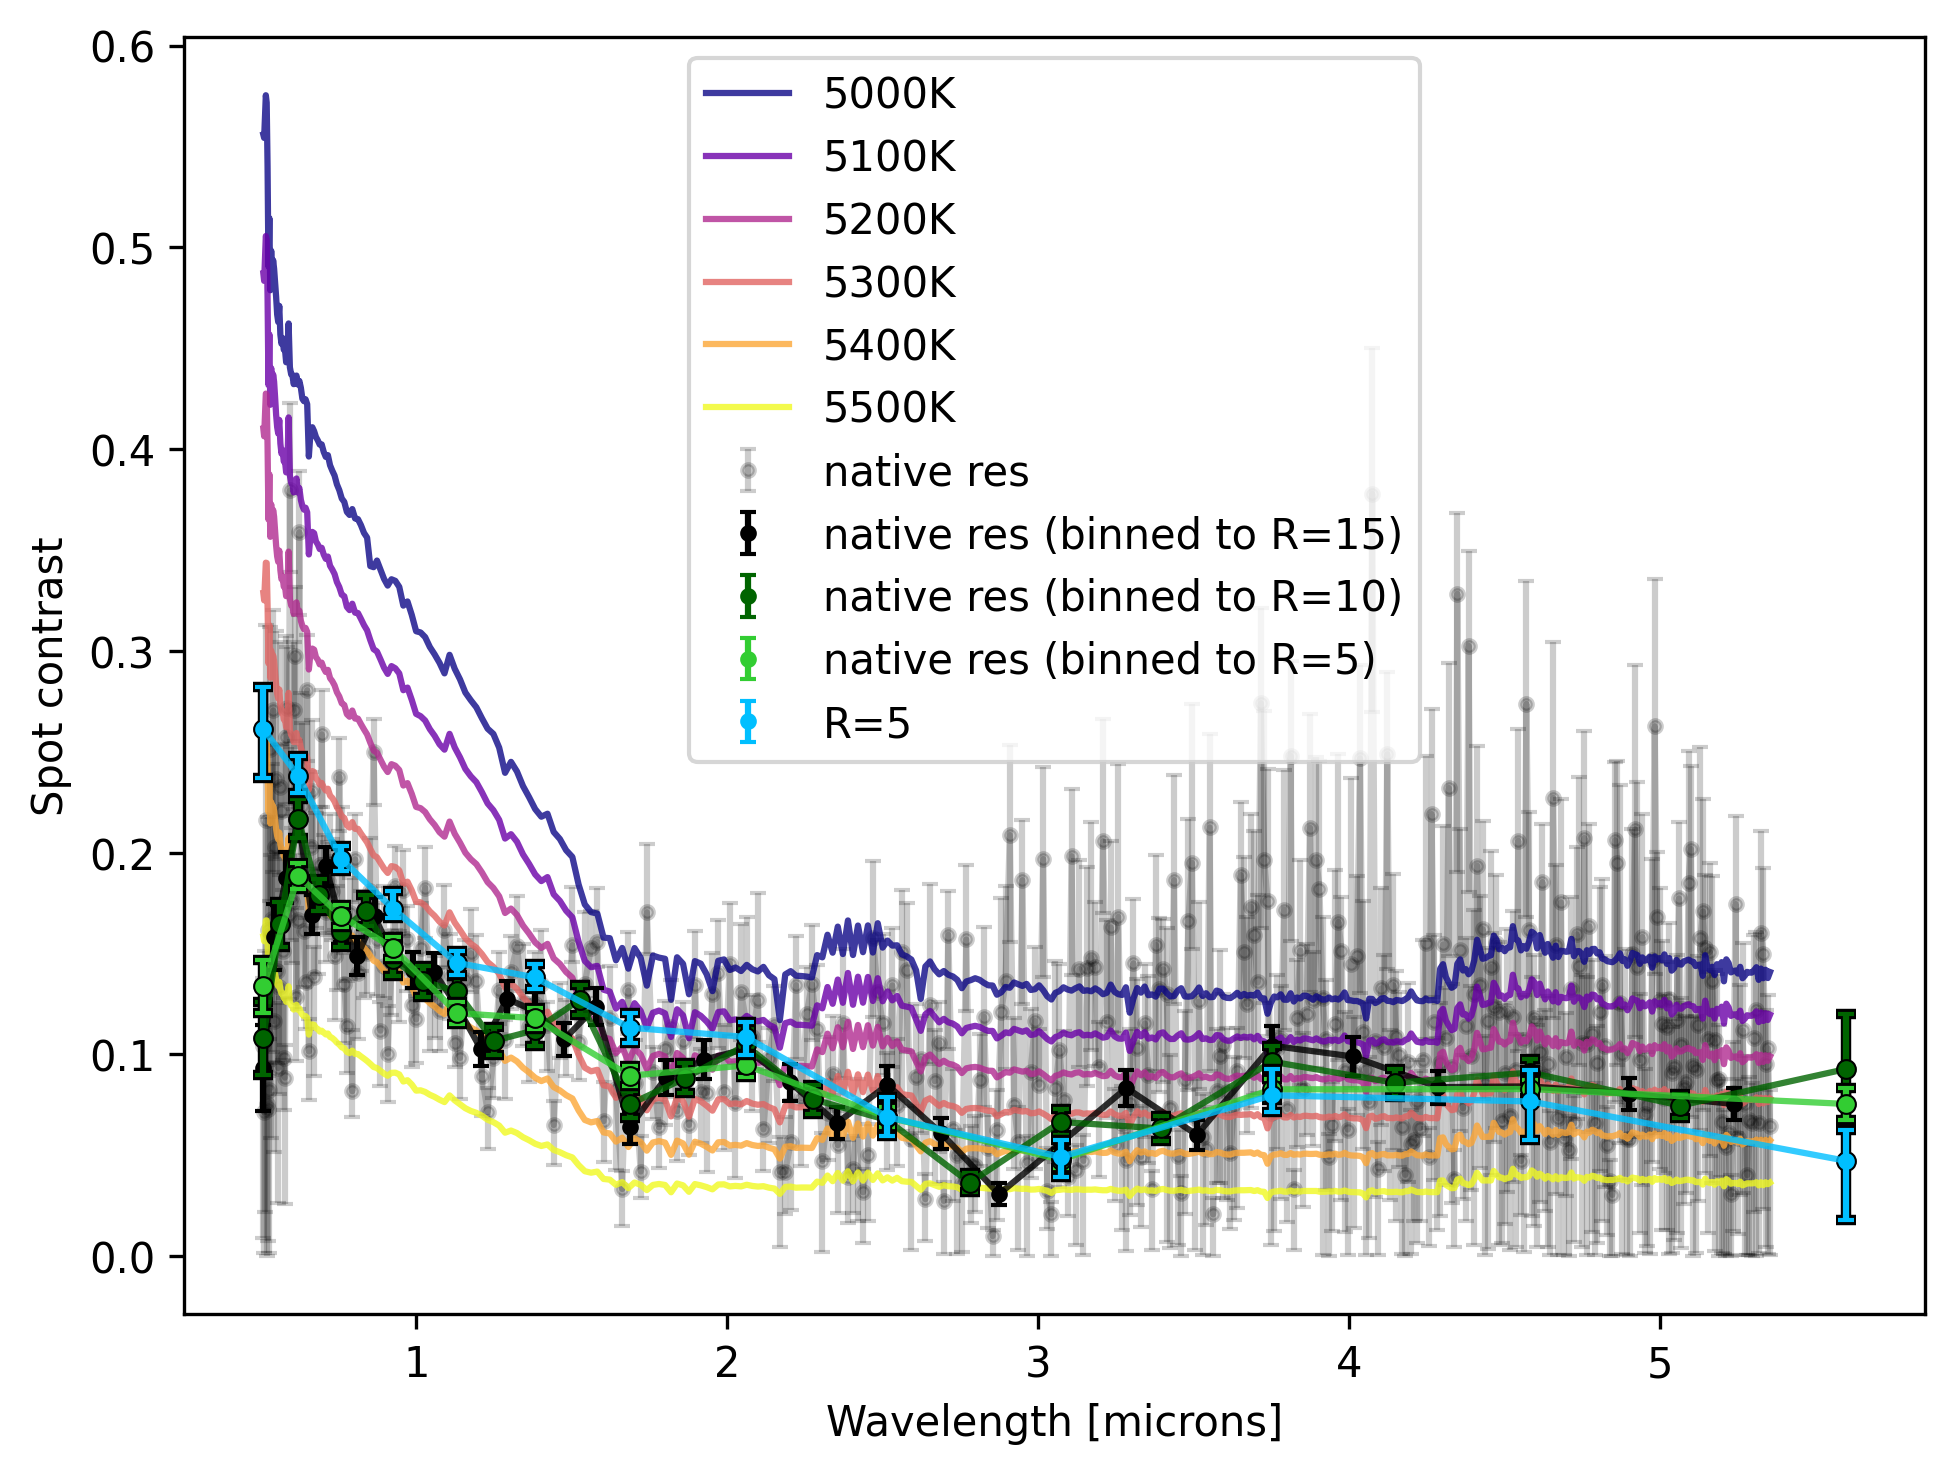

In [93]:
plt.plot(scont_all_df['wavelength'].values, scont_all_df['transitspot_spot_contrast'].values,'k-', alpha=0.2)
# plt.plot(scont_all_df['wavelength'].values, scont_all_df['transitspot_spot_contrast'].values,'k.')
plt.errorbar(scont_all_df['wavelength'].values, 
             scont_all_df['transitspot_spot_contrast'].values,
             yerr = [scont_all_df['transitspot_spot_contrast_neg_error'].values,scont_all_df['transitspot_spot_contrast_pos_error'].values],
             fmt='k.', alpha=0.2, label="native res",  capsize=2, zorder=1)


color = 'k'
plt.errorbar(binned_scont_r15['x'], 
             binned_scont_r15['y'],
             yerr = binned_scont_r15['uncertainty'],
             fmt='.', color=color, alpha=1, label="native res (binned to R=15)",  capsize=2, zorder=3)
plt.plot(binned_scont_r15['x'], binned_scont_r15['y'],'-', color=color, alpha=0.8, zorder=3)

color = 'darkgreen'
# plt.plot(binned_scont_r10['x'], binned_scont_r10['y'],'-', color=color, alpha=0.8, zorder=10)
plt.errorbar(binned_scont_r10['x'], 
             binned_scont_r10['y'],
             yerr = binned_scont_r10['uncertainty'],
            fmt='o',color='k',capthick=2.5,elinewidth=2.5,capsize=2.5, markersize=4,zorder=4)
plt.errorbar(binned_scont_r10['x'], 
             binned_scont_r10['y'],
             yerr = binned_scont_r10['uncertainty'],
             fmt='.',color=color, alpha=1, label="native res (binned to R=10)",  capsize=2, zorder=4)
plt.plot(binned_scont_r10['x'], binned_scont_r10['y'],'-', color=color, alpha=0.8, zorder=4)

color = 'limegreen'
plt.errorbar(binned_scont_r5['x'], 
             binned_scont_r5['y'],
             yerr = binned_scont_r5['uncertainty'],
            fmt='o',color='k',capthick=2.5,elinewidth=2.5,capsize=2.5, markersize=4,zorder=5)
plt.errorbar(binned_scont_r5['x'], 
             binned_scont_r5['y'],
             yerr = binned_scont_r5['uncertainty'],
             fmt='.',color=color, alpha=1, label="native res (binned to R=5)",  capsize=2, zorder=5)
plt.plot(binned_scont_r5['x'], binned_scont_r5['y'],'-',color=color, alpha=0.8, zorder=5)

color='deepskyblue'
# plt.plot(scont_r5['wavelength'].values, scont_r5['transitspot_spot_contrast'],'-', color=color, alpha=0.8)
# plt.plot(scont_r5['wavelength'].values, scont_r5['transitspot_spot_contrast'],'.', color=color)
plt.errorbar(scont_r5['wavelength'].values, 
             scont_r5['transitspot_spot_contrast'].values,
             yerr = [scont_r5['transitspot_spot_contrast_neg_error'].values,scont_r5['transitspot_spot_contrast_pos_error'].values],
            fmt='o',color='k',capthick=2.5,elinewidth=2.5,capsize=2.5, markersize=4,zorder=8)
plt.errorbar(scont_r5['wavelength'].values, 
             scont_r5['transitspot_spot_contrast'].values,
             yerr = [scont_r5['transitspot_spot_contrast_neg_error'].values,scont_r5['transitspot_spot_contrast_pos_error'].values],
             fmt='.', color=color, alpha=1.0, label="R=5", capsize=2, zorder=9)
plt.plot(scont_r5['wavelength'].values, scont_r5['transitspot_spot_contrast'],'-', color=color, alpha=0.8, zorder=10)
# color='darkred'
# # plt.plot(scont_r5_y26['wavelength'].values, scont_r5_y26['transitspot_spot_contrast'],'-', color='c', alpha=0.8)
# plt.plot(scont_r5_y26['wavelength'].values, scont_r5_y26['transitspot_spot_contrast'],'.', color=color)
# plt.errorbar(scont_r5_y26['wavelength'].values, 
#              scont_r5_y26['transitspot_spot_contrast'].values,
#              yerr = [scont_r5_y26['transitspot_spot_contrast_neg_error'].values,scont_r5_y26['transitspot_spot_contrast_pos_error'].values],
#              fmt='.', color=color, alpha=1.0, label="R=5 (ydeg=26)", capsize=2, zorder=10)


plt.xlabel("Wavelength [microns]")
plt.ylabel("Spot contrast")

import matplotlib as pl
# col = pl.cm.jet()  
plot_temps=True
if plot_temps:
    from chromatic_fitting.jwst.jwst_utils import get_spot_contrast
    import math 
    
    spot_rad = np.sin(14.98 * u.degree)
    
    contrast = {}
    for i, steff in enumerate(np.linspace(5000, 5500,6)):
        contrast[steff] = get_spot_contrast(wavelengths=scont_all_df['wavelength'].values * u.micron,
                          star_teff=5670,
                          spot_teff=steff,
                          spot_radii=[spot_rad],
                         logg=4.7)
        plt.plot(scont_all_df['wavelength'].values,contrast[steff], label=f"{round(steff)}K", color=pl.cm.plasma(1-(5500-steff)/500), alpha=0.8)
    # plt.legend()
plt.legend()

plt.savefig("spot_contrast_comparison_native.png")


In [130]:
scont_all_df_to_save = scont_all_df.reset_index(drop=True)
scont_all_df_to_save.to_csv("spot_contrast_native.csv")